In [1]:
import os
import random

from catboost import CatBoostClassifier

import dateutil.relativedelta as relativedelta



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

import seaborn as sns
from typing import Any, List, Optional, Union, Tuple


In [2]:
# set N used in n-largest or smallest
N = 10


In [3]:
# set style
plt.style.use("seaborn-notebook")

# set ratio of figure
ratio = (16, 9)


In [4]:
# connect to google cloud storage
# auth.authenticate_user()
# credentials, _ = google.auth.default()
# fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
# fs_prefix = "gs://"


In [5]:
# set fixed seed
def seed_everything(seed) -> None:
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


This notebook performs an eda on the training set only to avoid data leakage. ⚠️

In [6]:
data = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet")

/usr/local/lib/python3.8/dist-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
data = data.sample(frac=0.1, axis=0, random_state=seed)

## Notes on data set 🗃️

**Overview on ticker symbols:**
- `others` identified by issue type.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)


**Issue Types:**

Issue Type = the type of security: 
- 0 = Common Stock 
- A = Market index 
- 7 = Mutual or investment trust fund 
- F = ADR/ADS 
- % = Exchange-traded fund 
- (blank) = Unspecified

Received from supervisor.

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, distributions, and memory consumption 🔭

In [8]:
data.head()


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,issue_type,myn,buy_sell
3249281,2006-09-06 15:15:23,YNU,2008-01-19,5.0,C,5,2.05,1.95,2.05,2.05,...,186.0,1.90,2.20,26165240.0,5.0,2.20,2.20,0,1.225000,1
11026460,2009-01-30 14:21:48,UFB,2009-05-16,22.5,P,5,5.30,5.20,5.30,5.30,...,5.0,5.10,4.90,46287840.0,5.0,4.90,4.00,0,1.119125,-1
11754654,2009-04-06 13:43:46,UZK,2009-04-18,55.0,C,1,0.20,0.10,0.20,0.20,...,307.0,0.15,0.15,45632176.0,1.0,0.12,0.07,0,0.837000,1
12792033,2009-07-07 09:46:26,ASJ,2009-09-19,16.0,C,1,3.00,2.95,3.00,3.00,...,10.0,2.70,2.65,46669576.0,10.0,2.70,3.90,0,1.068437,-1
27061954,2013-04-09 11:29:28,GG,2013-04-20,36.0,P,1,3.71,3.65,3.75,3.75,...,21.0,3.65,4.80,83130448.0,2.0,3.65,2.81,0,1.111969,1


In [9]:
data.describe()


,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,myn,buy_sell
count,2.951032e+06,2.951032e+06,2.951032e+06,2.951032e+06,2.951032e+06,2.917282e+06,2.917282e+06,2.917282e+06,2.917282e+06,2.863609e+06,2.897181e+06,2948341.0,2.951032e+06,2.740702e+06,2.779600e+06,2.945975e+06,2.951032e+06
mean,7.595303e+01,1.460281e+01,4.992070e+00,4.894021e+00,5.252241e+00,5.110988e+00,4.898716e+00,3.515543e+02,3.608992e+02,5.035118e+00,4.983459e+00,50335740.0,6.725793e+01,5.023964e+00,4.988567e+00,1.018480e+01,-5.885060e-02
std,1.879976e+02,7.494708e+01,1.413471e+01,1.403218e+01,1.753075e+02,1.429339e+01,1.406812e+01,1.421814e+03,1.491231e+03,1.569917e+01,1.392152e+01,22274910.0,3.436836e+02,1.410720e+01,1.383299e+01,2.123719e+03,9.982670e-01
min,5.000000e-01,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,21058526.0,1.000000e+00,1.000000e-02,1.000000e-02,6.478759e-07,-1.000000e+00
25%,2.250000e+01,2.000000e+00,5.500000e-01,5.000000e-01,6.000000e-01,6.000000e-01,5.000000e-01,2.200000e+01,2.500000e+01,5.900000e-01,5.800000e-01,32812544.0,4.000000e+00,6.000000e-01,6.100000e-01,8.639309e-01,-1.000000e+00
50%,4.000000e+01,5.000000e+00,1.750000e+00,1.700000e+00,1.800000e+00,1.850000e+00,1.700000e+00,7.300000e+01,7.800000e+01,1.800000e+00,1.790000e+00,45686300.0,1.000000e+01,1.800000e+00,1.800000e+00,9.606148e-01,-1.000000e+00
75%,6.600000e+01,1.000000e+01,4.650000e+00,4.500000e+00,4.750000e+00,4.800000e+00,4.500000e+00,2.610000e+02,2.690000e+02,4.700000e+00,4.650000e+00,62513352.0,3.800000e+01,4.680000e+00,4.670000e+00,1.056000e+00,1.000000e+00
max,7.900000e+03,4.000000e+04,1.266430e+03,1.264300e+03,2.000010e+05,1.270200e+03,1.264200e+03,9.999900e+04,9.999900e+04,9.999050e+03,1.275000e+03,127871976.0,4.400000e+04,1.285100e+03,1.260680e+03,1.789571e+06,1.000000e+00


In [10]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2951032 entries, 3249281 to 3360776
Data columns (total 22 columns):
 #   Column          Dtype         
---  ------          -----         
 0   QUOTE_DATETIME  datetime64[ns]
 1   ROOT            object        
 2   EXPIRATION      datetime64[ns]
 3   STRK_PRC        float32       
 4   OPTION_TYPE     category      
 5   TRADE_SIZE      int64         
 6   TRADE_PRICE     float32       
 7   BEST_BID        float32       
 8   BEST_ASK        float32       
 9   ask_ex          float32       
 10  bid_ex          float32       
 11  bid_size_ex     float32       
 12  ask_size_ex     float32       
 13  price_all_lead  float32       
 14  price_all_lag   float32       
 15  optionid        float32       
 16  day_vol         float32       
 17  price_ex_lead   float32       
 18  price_ex_lag    float32       
 19  issue_type      object        
 20  myn             float32       
 21  buy_sell        int8          
dtypes: category(

In [11]:
print(data.shape)


(2951032, 22)


In [12]:
print(data.shape)
# drop identical rows, if present
data.drop_duplicates(inplace=True)
print(data.shape)


(2951032, 22)
(2946810, 22)


**Observation:**
- Shape matches the shape reported in table 1 (panel A) of Grauer et al. paper.
- No duplicates

In [13]:
data.nunique()


QUOTE_DATETIME    2740379
ROOT                 8667
EXPIRATION            286
STRK_PRC             1570
OPTION_TYPE             2
TRADE_SIZE           1602
TRADE_PRICE         15887
BEST_BID             7618
BEST_ASK             7694
ask_ex               7667
bid_ex               7592
bid_size_ex         14751
ask_size_ex         15177
price_all_lead      14457
price_all_lag       14392
optionid           793238
day_vol              3573
price_ex_lead       15386
price_ex_lag        15188
issue_type              5
myn                637012
buy_sell                2
dtype: int64

In [14]:
data.head().T


,3249281,11026460,11754654,12792033,27061954
QUOTE_DATETIME,2006-09-06 15:15:23,2009-01-30 14:21:48,2009-04-06 13:43:46,2009-07-07 09:46:26,2013-04-09 11:29:28
ROOT,YNU,UFB,UZK,ASJ,GG
EXPIRATION,2008-01-19 00:00:00,2009-05-16 00:00:00,2009-04-18 00:00:00,2009-09-19 00:00:00,2013-04-20 00:00:00
STRK_PRC,5.0,22.5,55.0,16.0,36.0
OPTION_TYPE,C,P,C,C,P
TRADE_SIZE,5,5,1,1,1
TRADE_PRICE,2.05,5.3,0.2,3.0,3.71
BEST_BID,1.95,5.2,0.1,2.95,3.65
BEST_ASK,2.05,5.3,0.2,3.0,3.75
ask_ex,2.05,5.3,0.2,3.0,3.75


## Basic features🧸

Analysis of numerical features without any feature engineering.

### Correlations 🎲

<ipython-input-15-26b19749daf2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr: pd.DataFrame = data.corr()


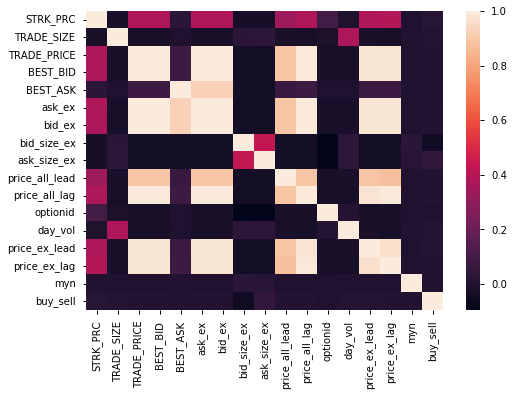

In [15]:
corr: pd.DataFrame = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


**Observation:**
* There are many highly correlated columns. The correlations are intuitive e. g., between `price_all_lead` and `price_ex_lead`.
* Few columns show a weak correlation with target (see also below).

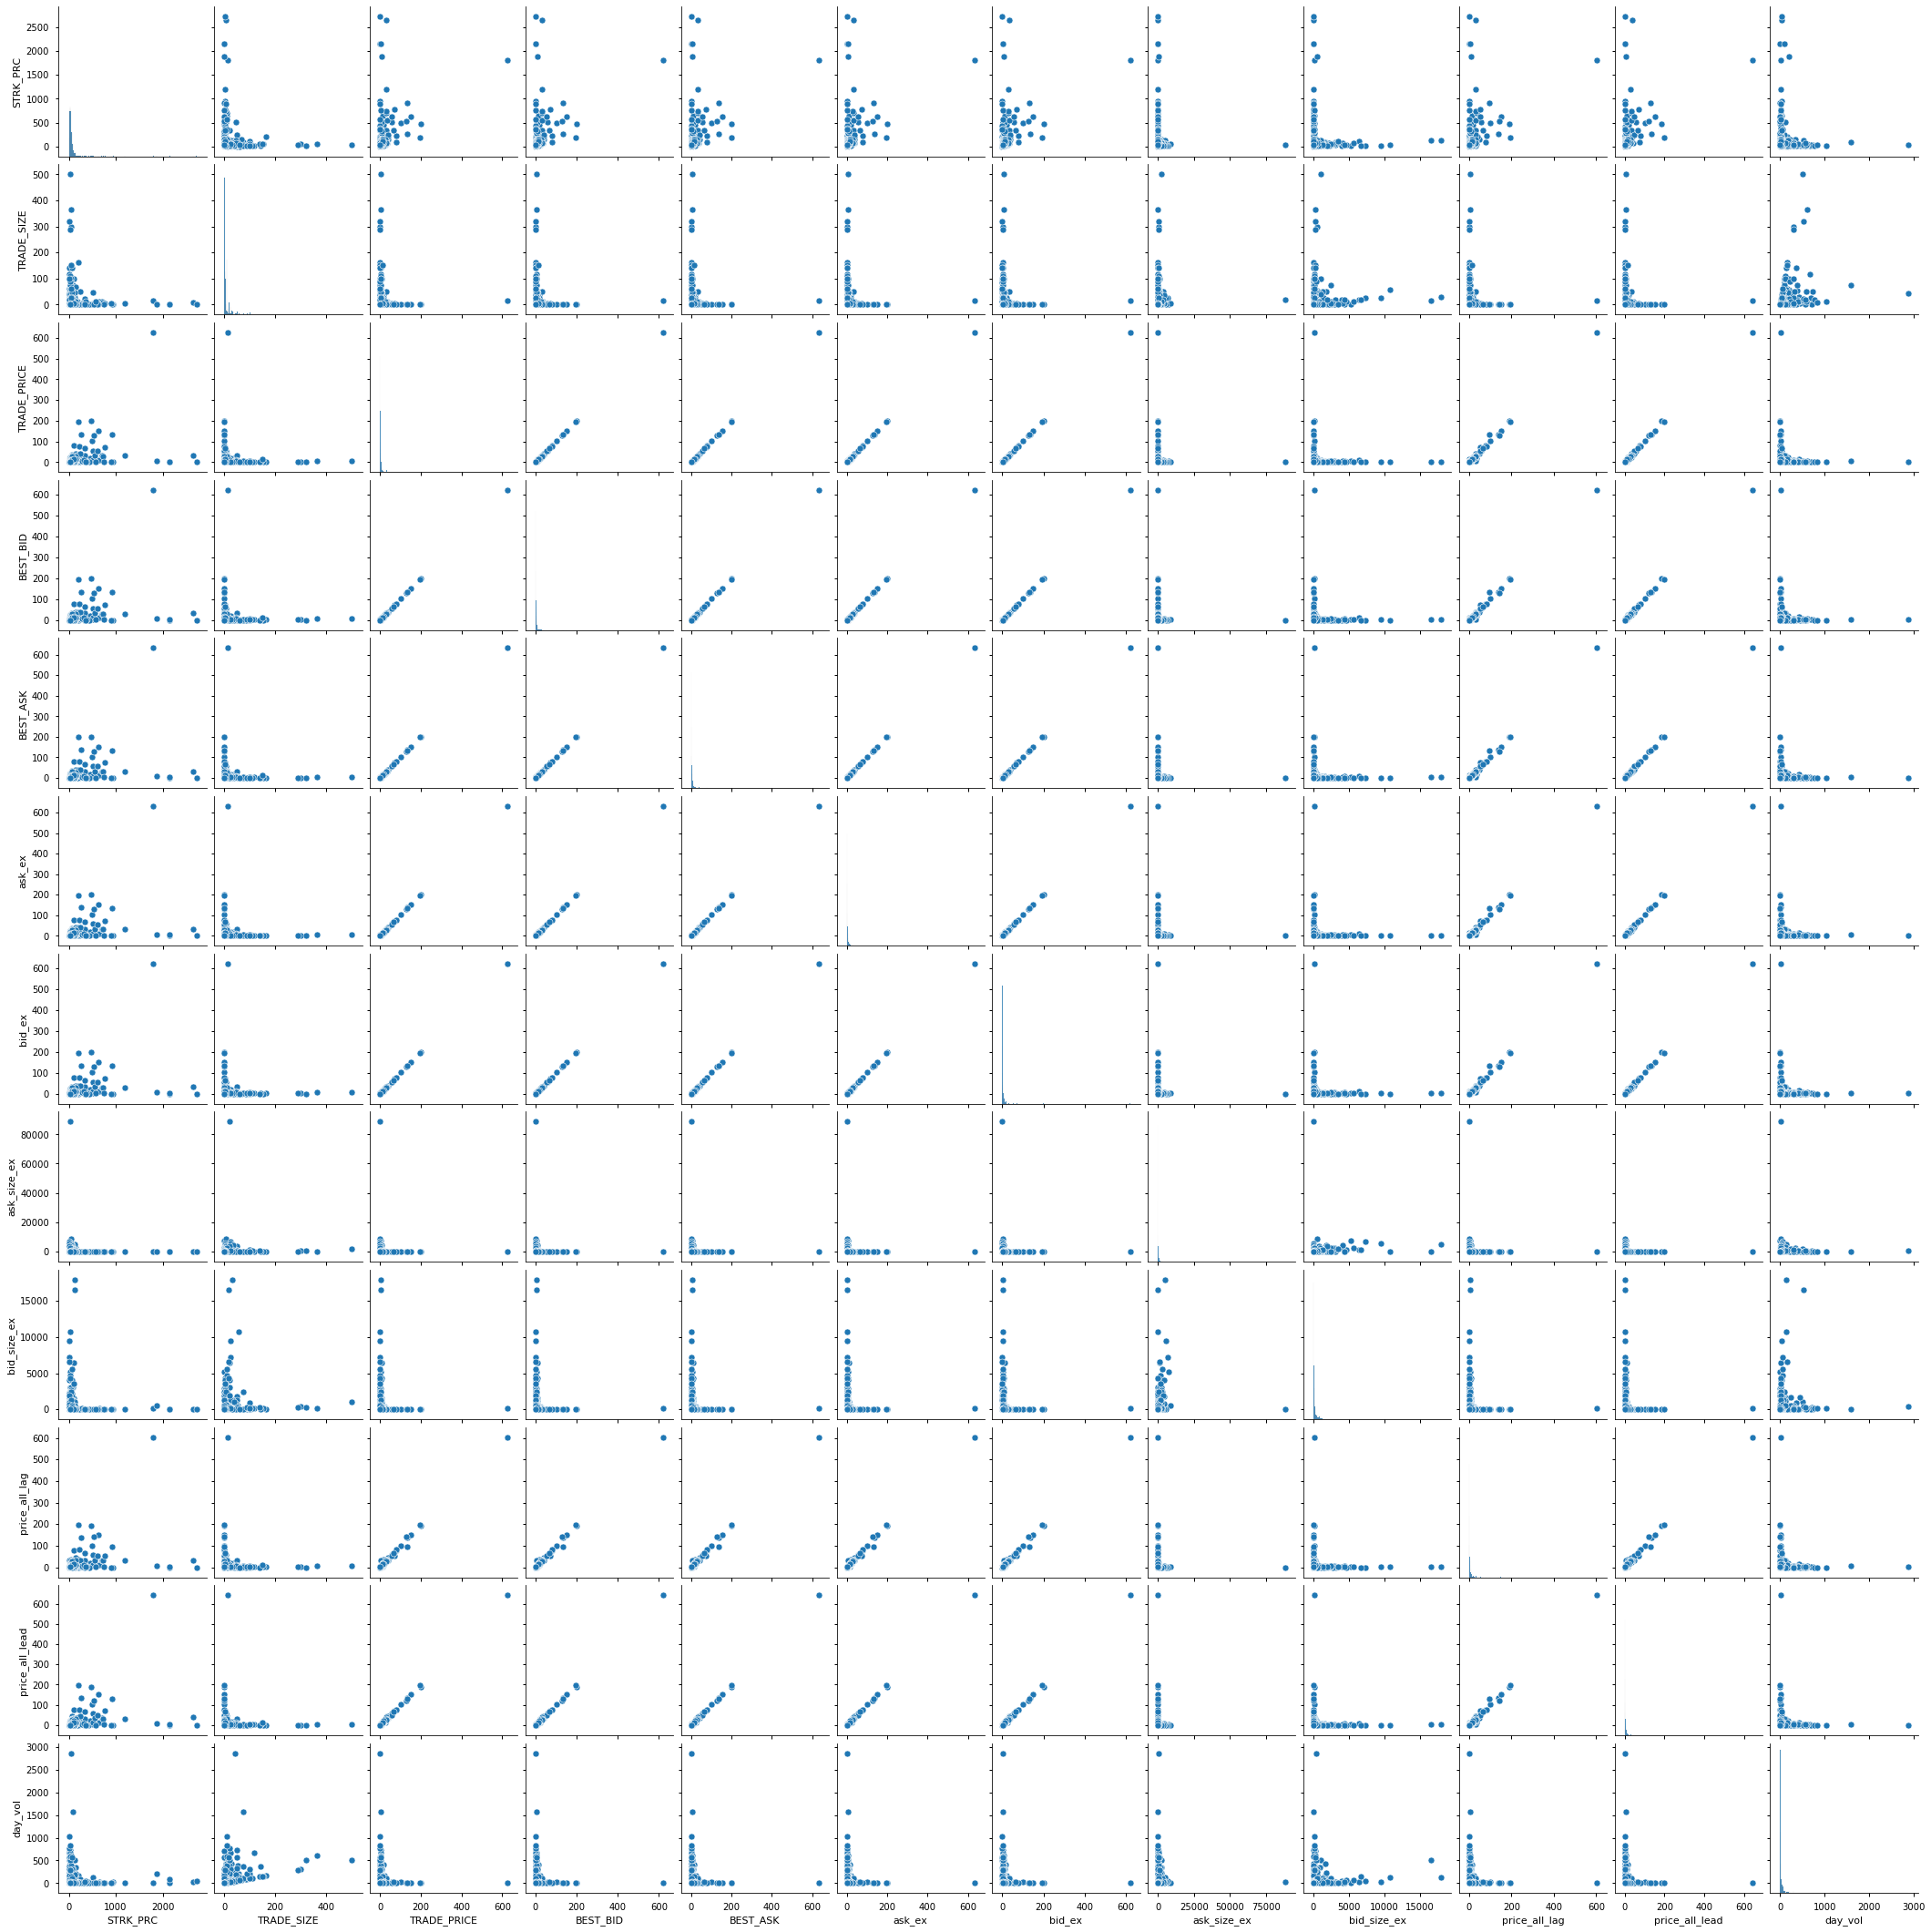

In [16]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(
    sample,
    vars=[
        "STRK_PRC",
        "TRADE_SIZE",
        "TRADE_PRICE",
        "BEST_BID",
        "BEST_ASK",
        "ask_ex",
        "bid_ex",
        "ask_size_ex",
        "bid_size_ex",
        "price_all_lag",
        "price_all_lead",
        "day_vol",
    ],
)


### Correlation with target 🎲

In [17]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
ask_size_ex,0.047890
bid_size_ex,-0.046578
STRK_PRC,0.019091
day_vol,0.012121
TRADE_SIZE,0.009560
price_ex_lead,0.008749
price_all_lead,0.006131
TRADE_PRICE,0.005401
price_ex_lag,0.005335


**Observation:**
* Overall correlations are relatively low. Typical for financial data due to low signal-to-noise ratio.
* Size-related features like `ask_size_ex` or `bid_size_ex` have the highest correlation with the target. Thus, can be promising to be included in the model. Consider size features when constructing feature sets.
* Features like `optionid`, `order_id`, and `SEQUENCE_NUMBER` are also among the features with the highest correlations. Remove them, as the correlation is misleading.

In [18]:
# remove some columns, which will NOT be used in model
data.drop(columns=["optionid"], inplace=True)


### Collinearity of features 🎲

In [19]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good
threshold = 0.975
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.975
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag']


**Observation:**
- Columns suggested for removal are intuitive
- Do not blindly remove columns, but preserve a pattern or groups

In [20]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])


In [21]:
pd.Series(above_threshold_vars)


STRK_PRC                                                 [STRK_PRC]
TRADE_SIZE                                             [TRADE_SIZE]
TRADE_PRICE       [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID          [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                                 [BEST_ASK]
ask_ex            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                           [bid_size_ex]
ask_size_ex                                           [ask_size_ex]
price_all_lead                                     [price_all_lead]
price_all_lag     [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
optionid                                                 [optionid]
day_vol                                                   [day_vol]
price_ex_lead     [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
price_ex_lag      [TRADE_PRICE, BEST_BID, ask_ex

**Observations:**
* Some columns are highly correlated. This is very intuitive.
* It seems problematic to include both `BEST_BID` and `bid_ex`. This is also true for `BEST_ASK` and `ask_ex`. `price_all_lead` and `price_all_lag` seem to be less problematic.
* Define feature sets so that the number of highly correlated variables is minimized. But maintain groups so that a comparsion with classical rules is still possible.

## Preparation 🥗

### Time features ⏰

In [22]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24 * 60 * 60
seconds = (
    data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
).dt.total_seconds()

data["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day, month and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["month"] = data["QUOTE_DATETIME"].dt.month
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date


### Binned features 🥫

Bin features similarily to how they are used in the robustness tests.

In [23]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)


### Trade features 💴
Construct features that are used in classical rules.

In [24]:
# spread in $ between ask and bid
data["spread_ex"] = data["ask_ex"] - data["bid_ex"]

# Calculate change similar to tick rule
data["chg_lead_ex"] = data["TRADE_PRICE"] - data["price_ex_lead"]

# Calculate change similar to reverse tick rule
data["chg_lag_ex"] = data["TRADE_PRICE"] - data["price_ex_lag"]

# Midspread
mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])

# ratio of bid-ask
data["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]

# Absolute distance from mid
data["abs_mid_ex"] = data["TRADE_PRICE"] - mid_ex
data["mid_ex"] = mid_ex

# Absolute distance from mid
data["abs_mid_BEST"] = data["TRADE_PRICE"] - mid_best
data["mid_best"] = mid_best

# depth rule (usually only applied to mid spread transactions)
data["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]

# Degree how much trade size is filled -> similar to trade size rule
# Trade size rule would just classify if
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# EMO / CLNV
data["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
data["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])

# EMO / CLNV
data["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
data["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])


### Underlying features 🫀

In [25]:
data["symbol_is_index"] = data["ROOT"].str.startswith("^").astype(int)


# TODO: Add majority class @ day


### Categorical features 🎰

### Visualization helper 🐜

In [26]:
def plot_kde_target(var_name: str, clip: Optional[List[float]] = None):
    """
  Plot kde plots for buys (+1) and sells (-1) with regard to \
  the feature 'var_name'.

   Args:
      var_name (str): name of the feature
      clip (Optional[List[float]], optional): clipping range. Defaults to None.
  """
    corr_var = data["buy_sell"].corr(data[var_name])

    median_sell = data[data["buy_sell"] == -1][var_name].median()
    median_buy = data[data["buy_sell"] == 1][var_name].median()

    _, ax = plt.subplots()
    for i in [-1, 1]:
        sns.kdeplot(
            data=data[data["buy_sell"] == i],
            x=var_name,
            clip=clip,
            label=str(i),
            cumulative=False,
            common_grid=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()
    print(
        f"The correlation between '{var_name}' and the 'buy_sell' is {corr_var: 0.4f}"
    )
    print(f"Median value of sells = {median_sell: 0.4f}")
    print(f"Median value of buys = {median_buy: 0.4f}")


In [27]:
def plot_kde_target_comparsion(
    var_name: str,
    clip: Optional[List[float]] = None,
    years: List[int] = [2006, 2010, 2013],
) -> None:
    """
    Plot several kde plots side by side for the feature.

    Args:
        var_name (str): name of the feature
        clip (Optional[List[float]], optional): clipping range. Defaults to None.
        years (List[int], optional): years to compare. Defaults to [2006, 2010, 2013].
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

    fig.suptitle(f"Distribution of `{var_name}`")

    for y, year in enumerate(years):
        for i in [-1, 1]:
            sns.kdeplot(
                data=data[(data["buy_sell"] == i) & (data["year"] == year)],
                x=var_name,
                clip=clip,
                # supress any other but first label using '_'
                # see https://stackoverflow.com/a/44633022/5755604
                label="_" * y + str(i),
                cumulative=False,
                common_grid=True,
                ax=ax[y],
            )
            ax[y].xaxis.label.set_text(str(year))

    fig.legend()


In [28]:
us_rec = web.DataReader("USREC", "fred", data["date"].min(), data["date"].max())


def plot_recessions() -> None:
    """
    Add recession indicator to plot and entry to legend.
    """
    l = 0
    month = relativedelta.relativedelta(months=+1)
    for date, val in us_rec["USREC"].items():
        if val == 1:
            # if boolean = 1 -> print bar until next month
            # '_' labels are ignored in legend https://stackoverflow.com/a/44633022/5755604
            plt.axvspan(
                date,
                date + month,
                edgecolor="none",
                alpha=0.25,
                label="_" * l + "recession",
            )
            l += 1


In [29]:
def plot_time_series(
    feature: Union[str, List[str]], aggregation: Union[str, List[Any]] = "count"
) -> pd.DataFrame:
    """
    Plot feature over time. Aggregate using 'aggregation'.

    Args:
        feature (Union[str, List[str]]): feature to plot.
        aggregation (Union[str, List[Any]], optional): aggregation operation. Defaults to "count".

    Returns:
        pd.DataFrame: time series
    """
    if isinstance(feature, str):
        feature = [feature]
    if isinstance(aggregation, str):
        aggregation = [aggregation]

    time_series = data[feature].groupby(data["date"]).agg(aggregation)
    time_series.columns = time_series.columns.to_flat_index()

    ax = sns.lineplot(data=time_series)
    ax.yaxis.label.set_text(" / ".join(aggregation))
    ax.title.set_text(f"'{' / '.join(feature)}' over time")
    plot_recessions()
    ax.legend()
    plt.show()

    return time_series


In [30]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = data.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# assign "bin_" column prefix 
cat_columns_bin = ["bin_" + x for x in cat_columns]

# binarize categorical similar to Borisov et al.
data[cat_columns_bin] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])  # type: ignore


['ROOT', 'OPTION_TYPE', 'issue_type', 'date', 'TRADE_SIZE_binned', 'year_binned', 'ttm_binned']


## General overview 🌄

### Trade price and sizes 🤝

#### Trades over time ⌚

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


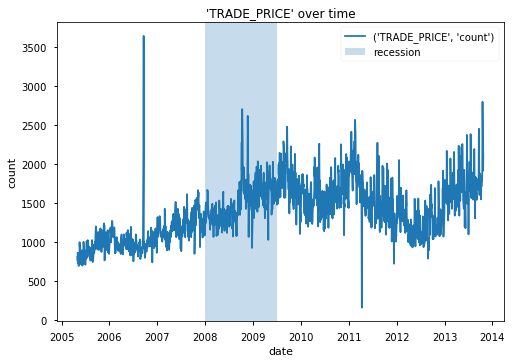

In [31]:
trades_per_day = plot_time_series("TRADE_PRICE", "count")


In [32]:
trades_per_day.iloc[:, 0].nlargest(N)


date
2006-09-19    3638
2013-10-18    2793
2008-10-10    2700
2008-11-21    2613
2011-02-18    2562
2009-09-16    2473
2009-09-18    2464
2008-11-20    2463
2013-09-20    2448
2011-01-21    2410
Name: (TRADE_PRICE, count), dtype: int64

In [33]:
trades_per_day.iloc[:, 0].nsmallest(N)


date
2011-04-11    154
2005-05-11    689
2005-06-08    693
2005-06-10    705
2005-07-01    705
2005-05-27    713
2011-12-12    718
2005-05-06    728
2006-11-24    735
2005-08-26    739
Name: (TRADE_PRICE, count), dtype: int64

**Observation:**
* Number of trades increases over time.
* There is no obvious explanation why the number of trades spikes at certain days.

#### Trade size

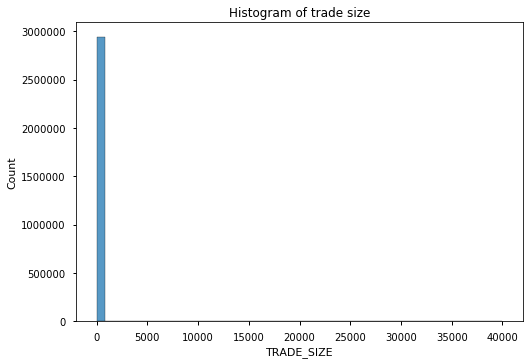

In [34]:
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade size")


**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform could help.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

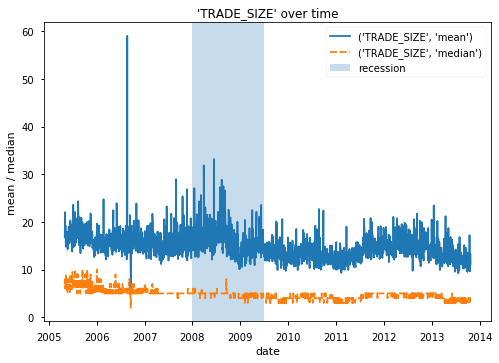

In [35]:
trades_over_time = plot_time_series("TRADE_SIZE", ["mean", "median"])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

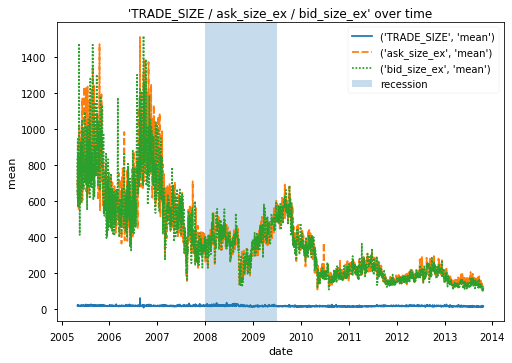

In [36]:
trade_ask_bid_size = plot_time_series(
    ["TRADE_SIZE", "ask_size_ex", "bid_size_ex"], "mean"
)


**Observation:**
* There is a slow downward trend in `TRADE_SIZE` (mean).
* Controversely, the number of trades per day (mean) increases over time.
* Market share of ISE has decrease over time, as reported in https://www.sifma.org/wp-content/uploads/2022/03/SIFMA-Insights-Market-Structure-Compendium-March-2022.pdf. 

In [37]:
data["TRADE_SIZE"].describe()


count    2.946810e+06
mean     1.461753e+01
std      7.499849e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      4.000000e+04
Name: TRADE_SIZE, dtype: float64

In [38]:
data[data["TRADE_SIZE"].max() == data["TRADE_SIZE"]]


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,BEST_rel_bid,BEST_rel_ask,symbol_is_index,bin_ROOT,bin_OPTION_TYPE,bin_issue_type,bin_date,bin_TRADE_SIZE_binned,bin_year_binned,bin_ttm_binned
3160192,2006-08-22 14:03:47,QAV,2006-10-21,32.0,P,40000,0.1,0.05,0.1,0.1,...,1.0,-1.0,0,510,1,1,129,3,0,3


In [39]:
data.nlargest(N, "TRADE_SIZE", keep="first").T


,3160192,8588493,17827624,12066837,11084912,12491904,9007495,17469012,9603295,1952893
QUOTE_DATETIME,2006-08-22 14:03:47,2008-06-13 11:44:24,2010-09-27 15:46:44,2009-05-04 13:55:17,2009-02-05 12:55:14,2009-06-09 15:20:32,2008-07-29 14:38:31,2010-08-25 10:58:15,2008-09-30 10:18:50,2006-02-22 13:47:15
ROOT,QAV,KEB,SMN1,URP,GLD,SZC,SFB,SPY,SPY,QQQ
EXPIRATION,2006-10-21 00:00:00,2010-01-16 00:00:00,2012-01-21 00:00:00,2009-08-22 00:00:00,2009-09-19 00:00:00,2009-06-20 00:00:00,2008-12-20 00:00:00,2010-09-30 00:00:00,2008-12-20 00:00:00,2006-05-20 00:00:00
STRK_PRC,32.0,12.5,15.0,22.5,88.0,77.0,133.0,85.0,127.0,40.0
OPTION_TYPE,P,P,C,P,C,C,C,P,P,P
TRADE_SIZE,40000,20000,17409,15000,12500,11477,11358,11000,10570,10000
TRADE_PRICE,0.1,3.15,0.6,0.4,12.57,17.870001,3.4,0.25,14.57,0.6
BEST_BID,0.05,3.1,0.6,0.3,12.2,17.65,3.4,0.23,14.55,0.55
BEST_ASK,0.1,3.8,1.15,0.4,12.6,17.9,3.45,0.26,14.75,0.6
ask_ex,0.1,3.8,1.15,0.4,12.6,17.9,3.55,0.26,14.75,0.65


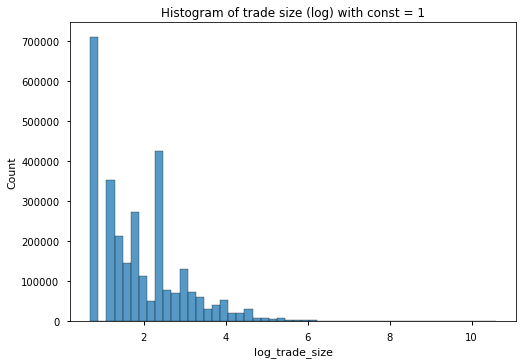

In [40]:
# const not really needed here, due to the trade size being >=1
const = 1
data["log_trade_size"] = np.log(data["TRADE_SIZE"] + const)
ax = sns.histplot(data, x="log_trade_size", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of trade size (log) with const = {const}")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

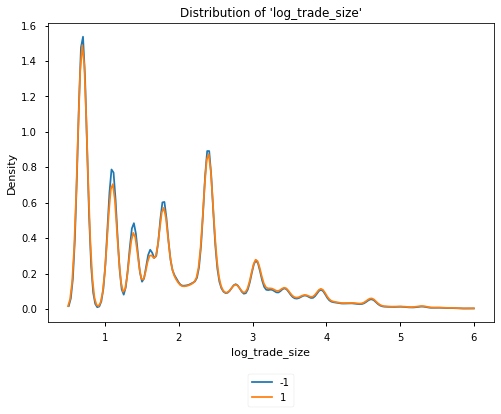

The correlation between 'log_trade_size' and the 'buy_sell' is  0.0162
Median value of sells =  1.7918
Median value of buys =  1.7918


In [41]:
plot_kde_target("log_trade_size", clip=[0, 6])


**Observation:**
- Size features do hardly profit from a $\log$ transform. Might want to keep as-is.

#### Trade price

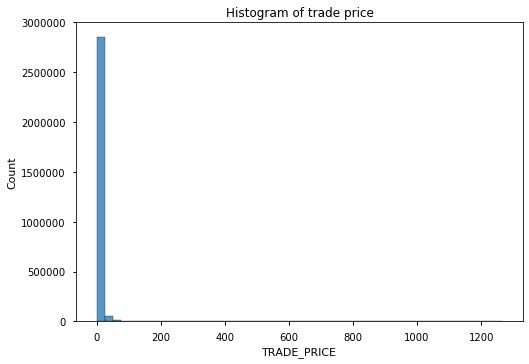

In [42]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade price")


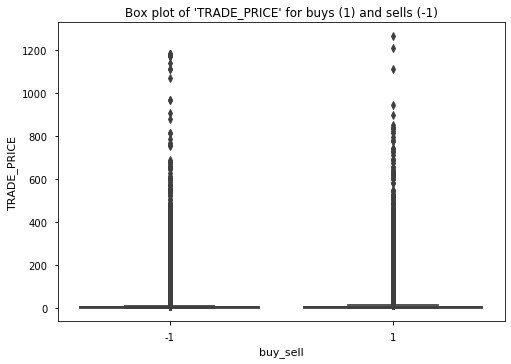

In [43]:
ax = sns.boxplot(data=data, x="buy_sell", y="TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few, very large trade prices, many very small trade prices.
* Scaling can be problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform to correct skewness of distribution. Could improve results.
* Trade price is hardly informative, as distribution is very similar.

In [44]:
const = 1e-2
data["log_trade_price"] = np.log(data["TRADE_PRICE"] + const)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


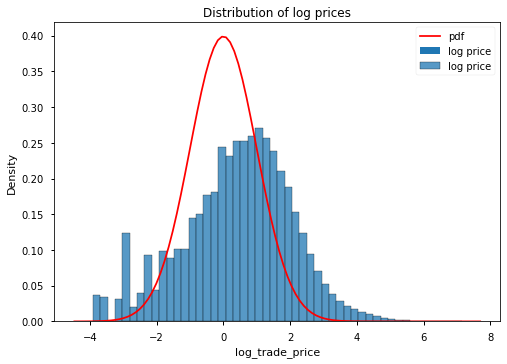

In [45]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat="density", label="log price")  # type: ignore

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({"x": x_pdf, "y": y_pdf})
sns.lineplot(data=pdf, x="x", y="y", label="pdf", color="r")


ax.title.set_text("Distribution of log prices")
ax.legend()


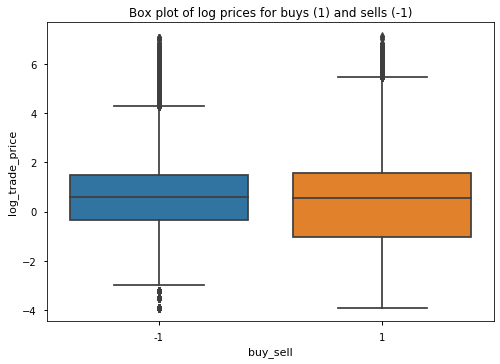

In [46]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")


In [47]:
data.nlargest(N, "TRADE_PRICE", keep="first").T


,14962176,15364463,14442297,14441737,14462547,14451647,14451656,14459254,14459252,14459239
QUOTE_DATETIME,2009-12-30 12:13:35,2010-02-05 14:29:22,2009-11-12 09:42:06,2009-11-12 09:36:19,2009-11-13 10:23:02,2009-11-12 12:57:25,2009-11-12 12:57:30,2009-11-13 09:32:16,2009-11-13 09:32:16,2009-11-13 09:32:07
ROOT,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK
EXPIRATION,2010-09-18 00:00:00,2010-09-18 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00
STRK_PRC,600.0,500.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
OPTION_TYPE,C,C,C,C,C,C,C,C,C,C
TRADE_SIZE,4000,300,10,4,8,1,14,10,10,1
TRADE_PRICE,1266.430054,1210.530029,1182.5,1182.5,1181.0,1180.5,1180.5,1178.5,1178.5,1178.5
BEST_BID,1264.300049,1204.5,1181.300049,1181.400024,1174.099976,1179.5,1179.900024,1177.699951,1177.699951,1177.400024
BEST_ASK,1270.099976,1216.900024,1182.5,1182.5,1181.0,1180.5,1182.099976,1178.5,1178.5,1178.5
ask_ex,1270.199951,1217.400024,1182.5,1182.5,1181.0,1180.5,1182.099976,1178.5,1178.5,1178.5


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

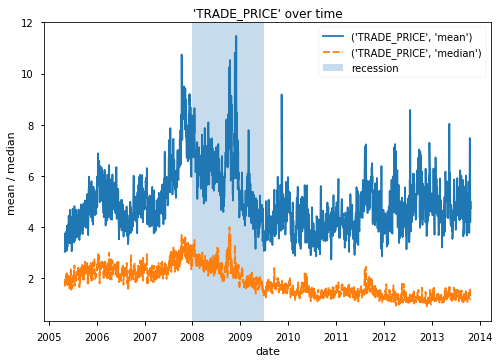

In [48]:
trade_price_over_time = plot_time_series("TRADE_PRICE", ["mean", "median"])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

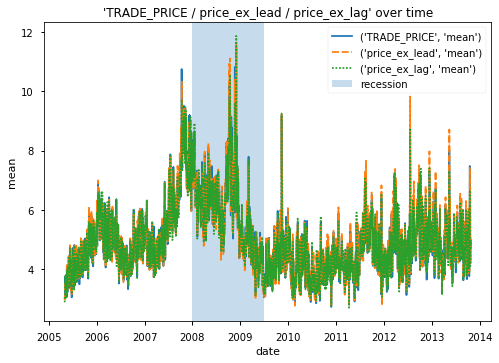

In [49]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "mean"
)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

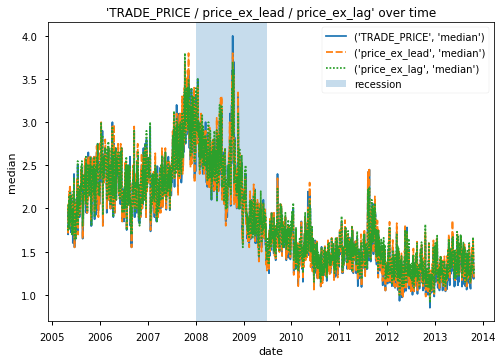

In [50]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "median"
)


**Observation:**
* `TRADE_PRICE` remains roughly constant over time. Median decreases over time.
* Large difference between median and mean. 

### Time to maturity ⌚

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


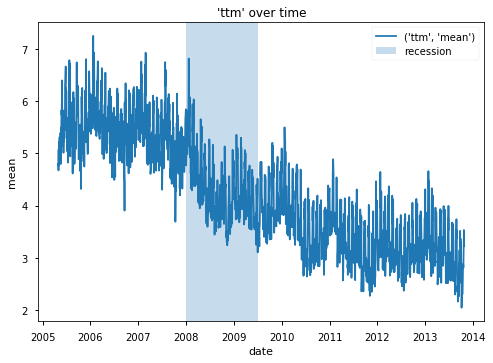

In [51]:
ttm_over_time = plot_time_series("ttm", "mean")


Text(0.5, 0.98, 'Trade Price vs. Time to Maturity')

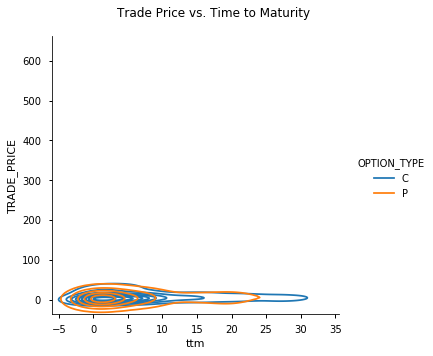

In [52]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data=sample, x="ttm", y="TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity")


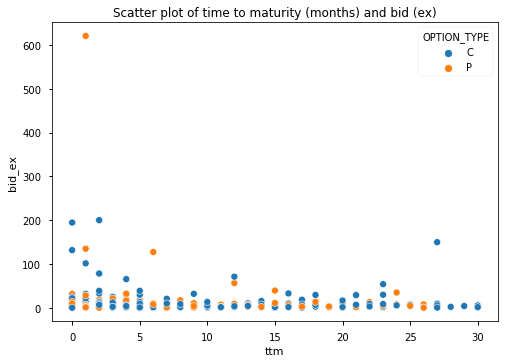

In [53]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


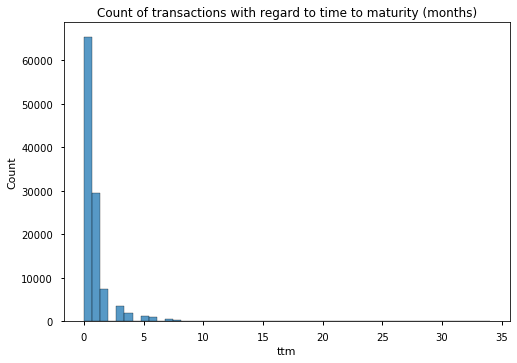

In [54]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


**Observation:**
- Most options have a short time-to-maturity
- Binning or cut-off could be helpful

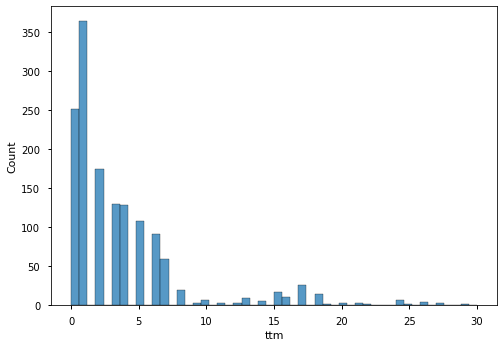

In [55]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


### Strike price

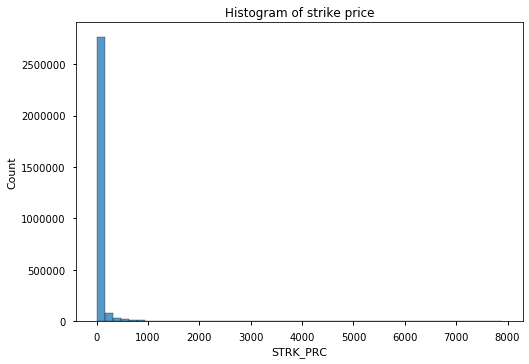

In [56]:
ax = sns.histplot(data, x="STRK_PRC", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price")


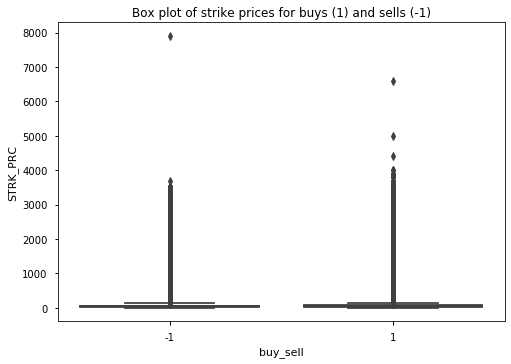

In [57]:
ax = sns.boxplot(data=data, x="buy_sell", y="STRK_PRC")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


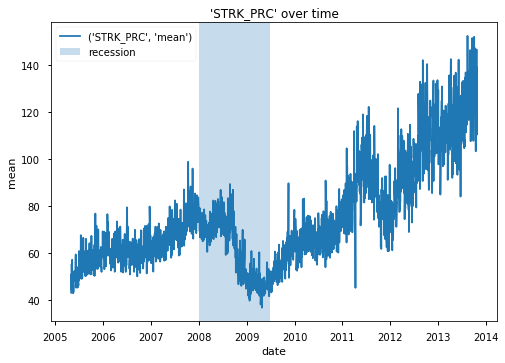

In [58]:
strike_over_time = plot_time_series("STRK_PRC", "mean")


**Observation:**
- Distribution of strike price is highly skewed
- Average strike price grows over time. Thus, very large and previously unobserved trade prices could be part of the test set, but not in the train set.
- Try $\log$

In [59]:
const = 1e-2
data["log_strk_prc"] = np.log(data["STRK_PRC"] + const)


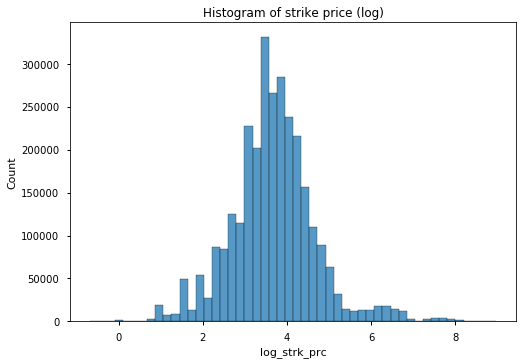

In [60]:
ax = sns.histplot(data, x="log_strk_prc", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price (log)")


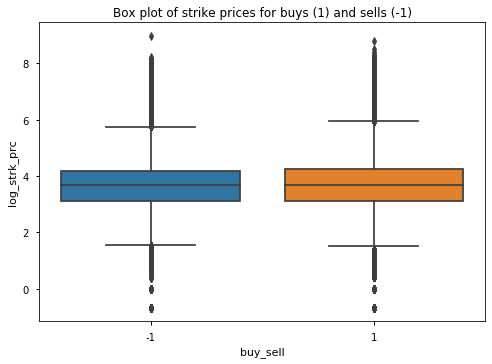

In [61]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_strk_prc")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


### Buy Sell 👛

In [62]:
ratio_buy_sell = data["buy_sell"].value_counts() / data["buy_sell"].count()
ratio_buy_sell.head()


-1    0.529536
 1    0.470464
Name: buy_sell, dtype: float64

**Observation:**
* Ratios similar to the one reported in Grauer et. al. Yet not identical as calculation is done on a sample.
* As both classes have a $\approx~0.5$ probability, I would not rebalance. Rebalancing through sampling etc. itself has a bias.
* Ratios seem to be stable over time (see below). Thus, distribution is similar for training, validation, and test set.
* With regard to time-to-maturity the distribution changes slightly for longer periods.

#### By option type

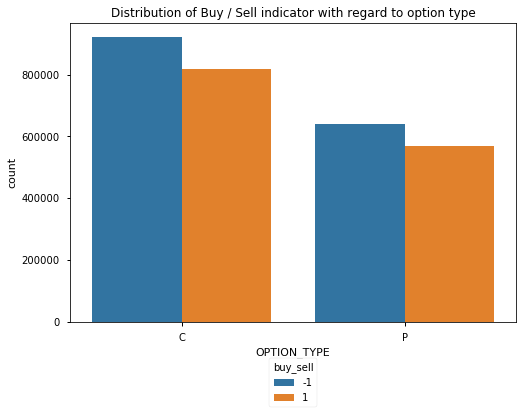

In [63]:
ax = sns.countplot(data=data, x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


#### By year

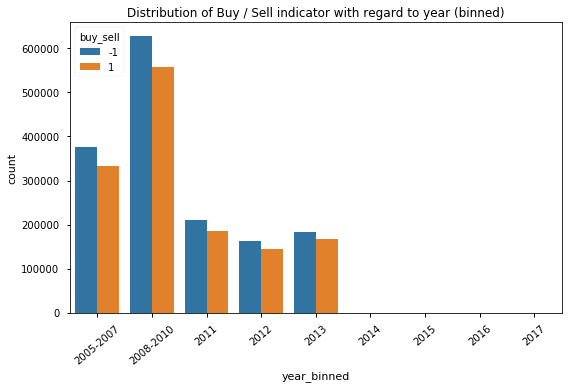

In [64]:
ax = sns.countplot(data=data, x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


#### By time time to maturity

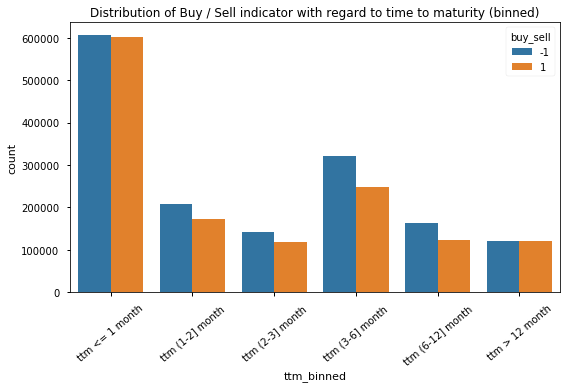

In [65]:
ax = sns.countplot(data=data, x="ttm_binned", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to time to maturity (binned)"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


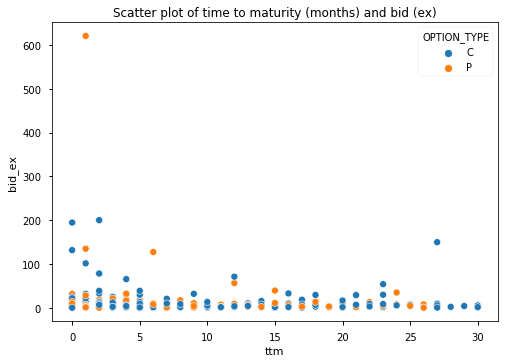

In [66]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


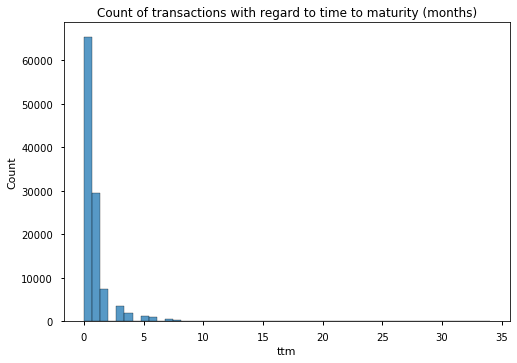

In [67]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


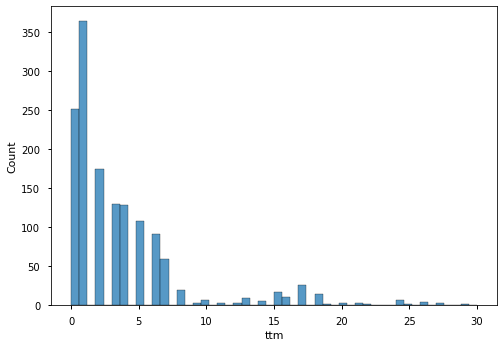

In [68]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


#### Over time

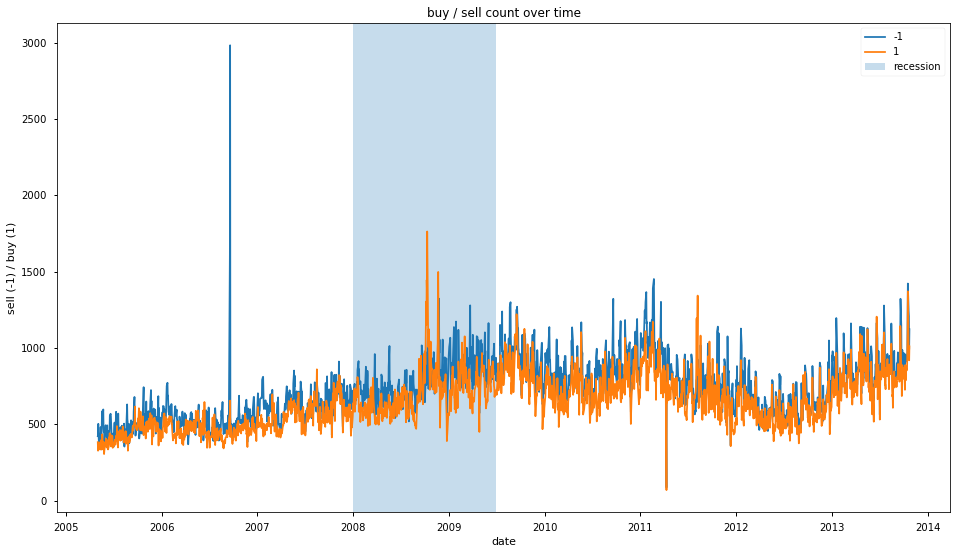

In [69]:
trades_over_time = (
    data.groupby(data["date"])["buy_sell"].value_counts().unstack(fill_value=0)
)
ax = trades_over_time.plot(
    kind="line",
    figsize=ratio,
    title="buy / sell count over time",
    xlabel="date",
    ylabel="sell (-1) / buy (1)",
)
plot_recessions()
ax.legend()
plt.show()


### $n$ most frequent symbols, indices, and special codes 🔢

,Symbol,Count
0,SPY,30678
1,AAPL,20141
2,GLD,20061
3,IWM,14731
4,RUT,14028
5,QQQ,11406
6,DIA,11057
7,GOOG,10261
8,NDX,10236
9,GDX,9825


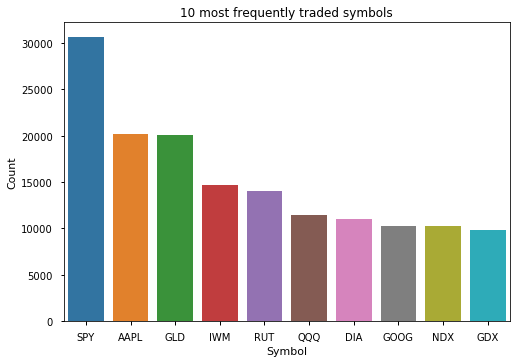

In [70]:
most_frequent_symbols = data["ROOT"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={"index": "Symbol"}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")

most_frequent_symbols.head(N)


In [71]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()


In [72]:
frequent_symbols_over_time = data[data["ROOT"].isin(list_freq_symbols)]


In [73]:
frequent_symbols_trades_per_day = (
    frequent_symbols_over_time.groupby(
        [frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period("m"), "ROOT"]
    )["TRADE_SIZE"]
    .count()
    .reset_index()
    .rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "ROOT": "Symbol"})
)


In [74]:
frequent_symbols_over_time = (
    frequent_symbols_trades_per_day.groupby(["date", "Symbol"])["count"]
    .first()
    .unstack()
)


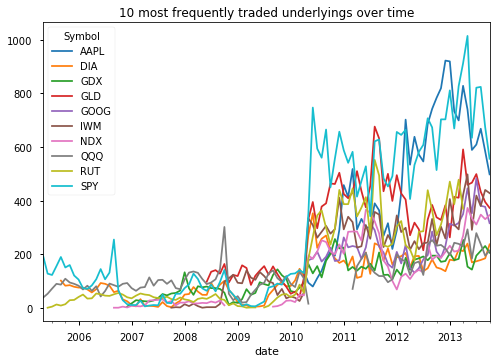

In [75]:
frequent_symbols_over_time.plot(
    kind="line", title=f"{N} most frequently traded underlyings over time"
)


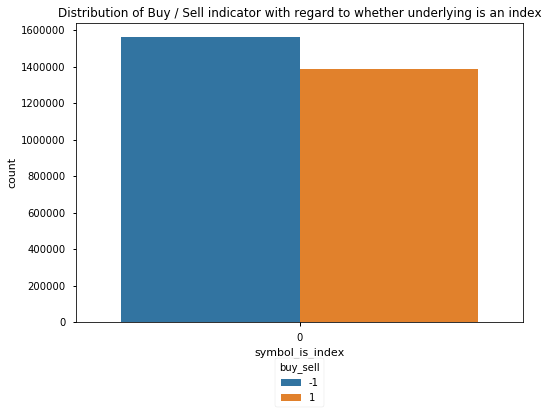

In [76]:
# TODO: investigate why there is no True group
ax = sns.countplot(data=data, x="symbol_is_index", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to whether underlying is an index"
)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


In [77]:
ratios_is_index = (
    data.groupby(["symbol_is_index", "buy_sell"])["buy_sell"].count()
    / data.groupby(["symbol_is_index"])["buy_sell"].count()
)
ratios_is_index.head()


symbol_is_index  buy_sell
0                -1          0.529536
                  1          0.470464
Name: buy_sell, dtype: float64

**Observation:**
- Feature can be important, as it's much more likely for trade to be sell, rather than buy, if and only if the underlying is no index option.
- Difference isn't too pronounced and could be due to sampling effects.

In [78]:
data["issue_type"].value_counts(dropna=False)


0       2244377
%        482280
F        173979
A         42042
None       3044
7          1088
Name: issue_type, dtype: int64

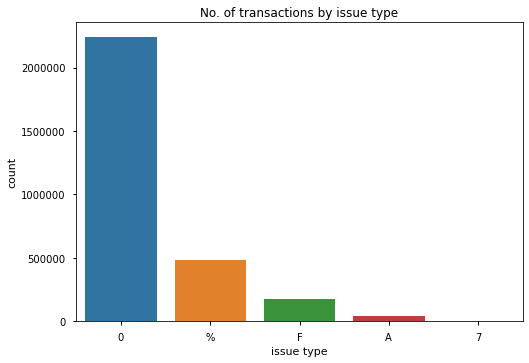

In [79]:
ax = sns.countplot(data=data, x="issue_type")
ax.title.set_text("No. of transactions by issue type")
ax.xaxis.label.set_text("issue type")


###  Ask and bid👨‍⚖️

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

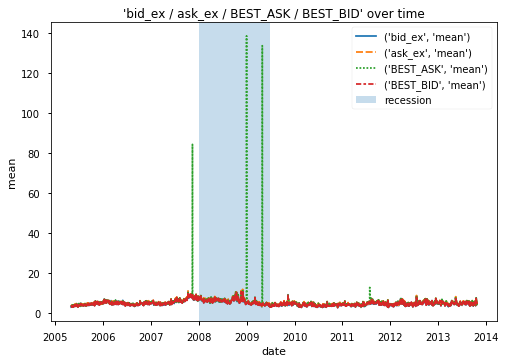

In [80]:
bid_ask_over_time = plot_time_series(
    ["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"], "mean"
)


#### Ask

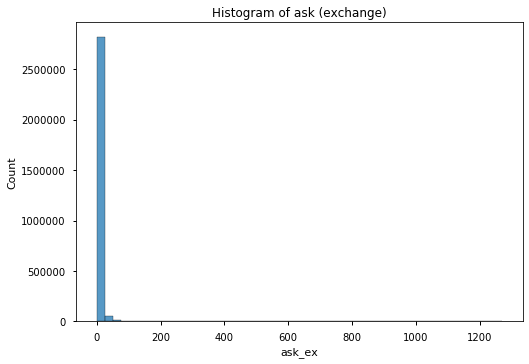

In [81]:
ax = sns.histplot(data, x="ask_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of ask (exchange)")


**Observation:**
* Distribution is highly skewed, try correction with $\log$

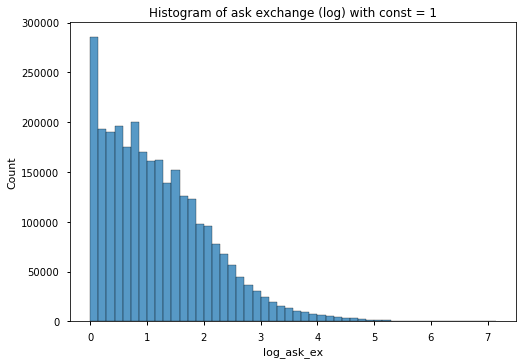

In [82]:
const = 1
data["log_ask_ex"] = np.log(data["ask_ex"] + const)
ax = sns.histplot(data, x="log_ask_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of ask exchange (log) with const = {const}")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

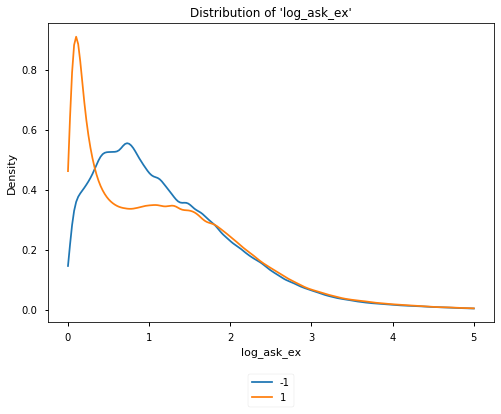

The correlation between 'log_ask_ex' and the 'buy_sell' is -0.0332
Median value of sells =  1.0578
Median value of buys =  1.0260


In [83]:
plot_kde_target("log_ask_ex", clip=[0, 5])


**Observation:**
* Applying a $\log$ transform leads to a easily distinguishable distribution

#### Bid

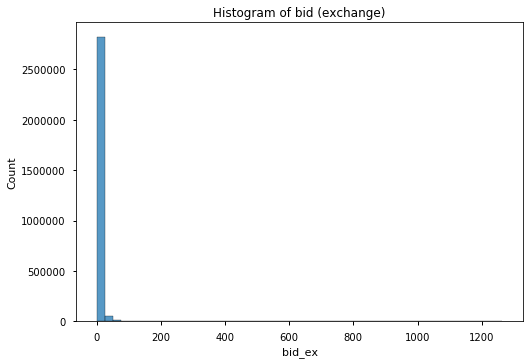

In [84]:
ax = sns.histplot(data, x="bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid (exchange)")


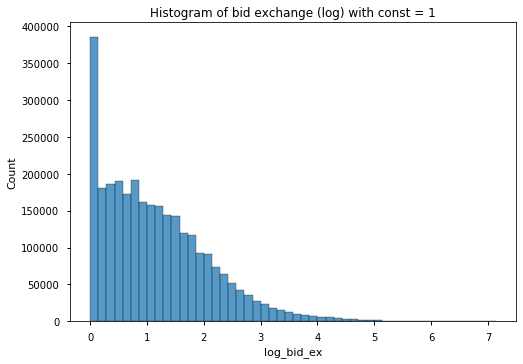

In [85]:
const = 1
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of bid exchange (log) with const = {const}")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

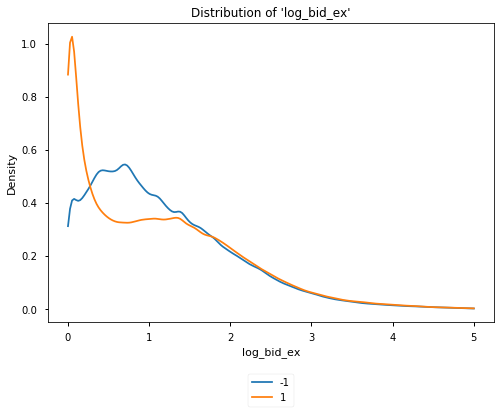

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0339
Median value of sells =  1.0116
Median value of buys =  0.9746


In [86]:
plot_kde_target("log_bid_ex", clip=[0, 5])


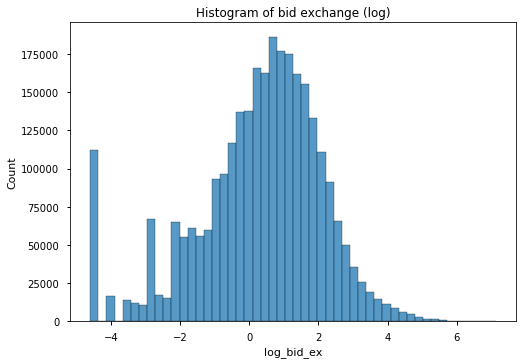

In [87]:
const = 1e-2
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid exchange (log)")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

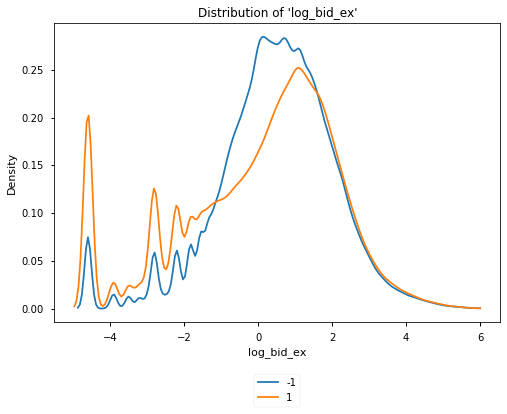

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1067
Median value of sells =  0.5653
Median value of buys =  0.5068


In [88]:
plot_kde_target("log_bid_ex", clip=[-5, 6])


**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy, yet distributions that are easier to distinguish. Also note the higher correlation with the target. 
- `TODO:` Look up typical constants to motivate the chosen constant in paper

**Observation:**
- log on size seems to worsen results.
- `TODO:` investigate further, what the reason is. e. g., how many outliers...

# NaNs 🪲

In [89]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()


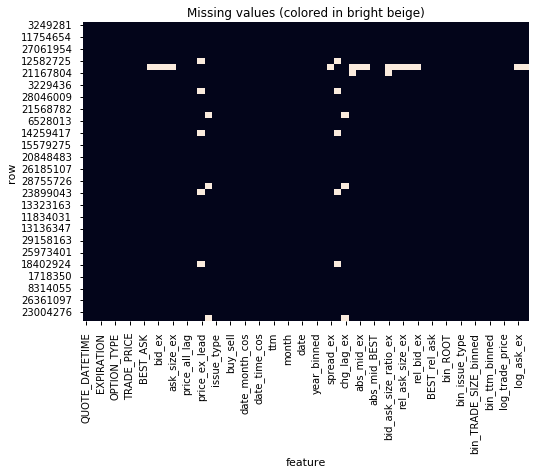

In [90]:
visualize_nan()


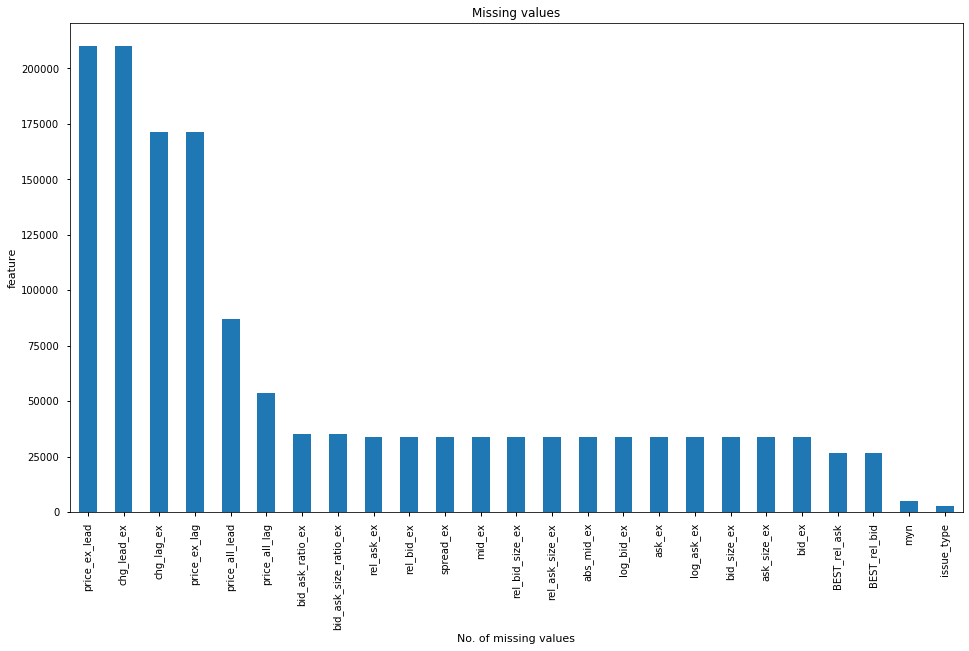

In [91]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(
    kind="bar",
    figsize=ratio,
    legend=False,
    xlabel="No. of missing values",
    ylabel="feature",
    title="Missing values",
)


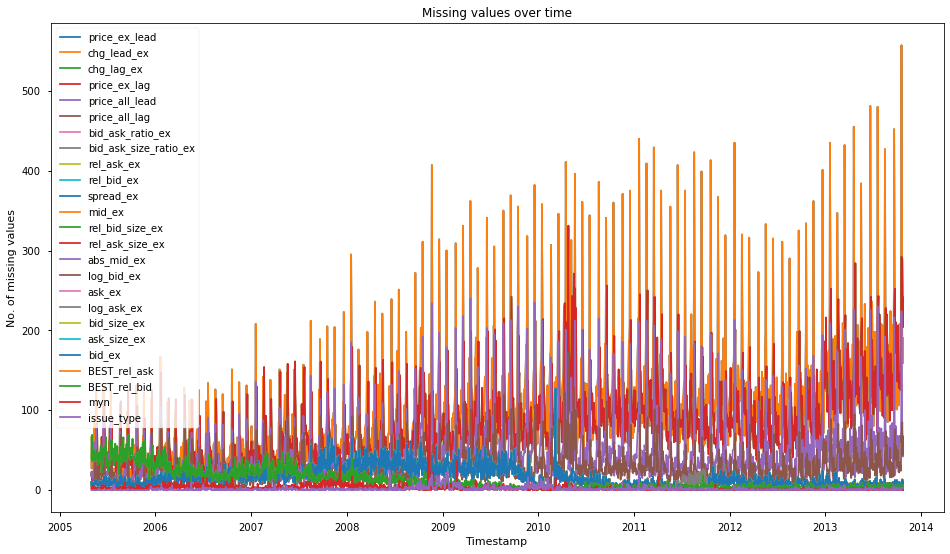

In [92]:
isna_vals_over_time = (
    data[isna_vals.index.tolist()]
    .groupby(data["QUOTE_DATETIME"].dt.date)
    .agg(lambda x: x.isnull().sum())
)
isna_vals_over_time.plot(
    kind="line",
    figsize=ratio,
    title="Missing values over time",
    xlabel="Timestamp",
    ylabel="No. of missing values",
)


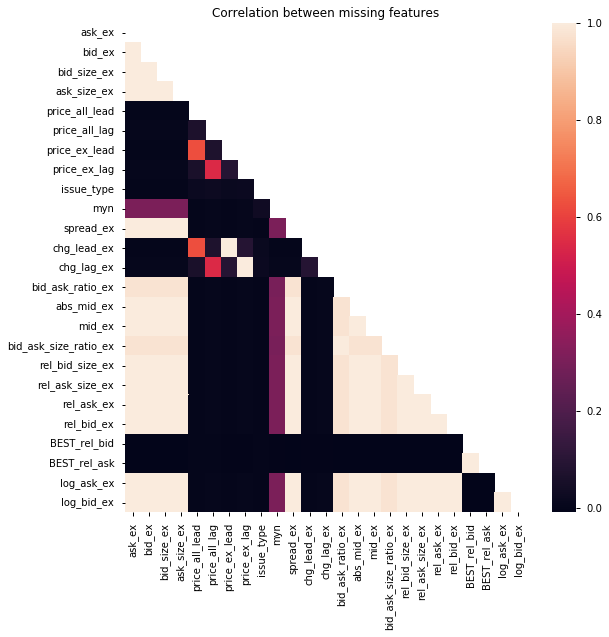

In [93]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[
    :, [i for i, n in enumerate(np.var(data.isnull(), axis="rows")) if n > 0]
]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={"size": 10}, ax=ax)
ax.title.set_text("Correlation between missing features")


In [94]:
# TODO: Check if there is a pattern between the missing values


**Observation:**
- Note that also important features like `price_all_lead` or `price_ex_lag` are missing. This has an impact, whether it is possible to calculate the classical rules like the trade rule. Consider this when reporting results.
- Missing values become more of a problem towards the end of the data set. At the same time the number of trades also increases.

# Correlations of engineered features 🎲

### Correlations 🎲

<ipython-input-95-ae1867dd9f6c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


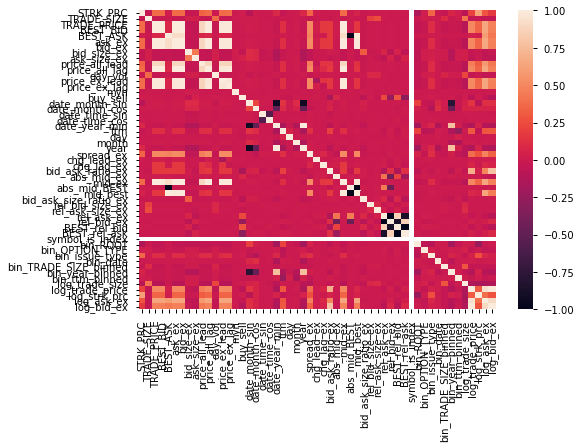

In [95]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


### Correlation with target 🎲

In [96]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
BEST_rel_bid,0.285073
BEST_rel_ask,-0.285073
rel_ask_ex,0.235650
rel_bid_ex,-0.235650
bid_ask_ratio_ex,-0.156145
log_bid_ex,-0.106741
abs_mid_ex,0.082089
log_trade_price,-0.077845
bid_ask_size_ratio_ex,-0.067924


In [97]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag', 'year', 'mid_ex', 'abs_mid_BEST', 'mid_best', 'rel_bid_ex', 'BEST_rel_ask', 'log_bid_ex']


**Observation:**
- Newly engineered features have a high correlation with the target, which is positive. Investigate if the correlation is due to randomness or whether a pattern is observable.
- `_ex` and `BEST_` features seem to be rather redundant, even if a high threshold for correlation is chosen.

### Collinearity of features🎲

In [98]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

pd.Series(above_threshold_vars)


STRK_PRC                                                        [STRK_PRC]
TRADE_SIZE                                                    [TRADE_SIZE]
TRADE_PRICE              [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID                 [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                              [BEST_ASK, mid_best]
ask_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                                  [bid_size_ex]
ask_size_ex                                                  [ask_size_ex]
price_all_lead                                            [price_all_lead]
price_all_lag            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
day_vol                                                          [day_vol]
price_ex_lead            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
price_ex_lag             

# Analyses of engineered features

In [99]:
corr_target.loc[sort_criteria.index].to_frame().T


,buy_sell,BEST_rel_bid,BEST_rel_ask,rel_ask_ex,rel_bid_ex,bid_ask_ratio_ex,log_bid_ex,abs_mid_ex,log_trade_price,bid_ask_size_ratio_ex,...,year,abs_mid_BEST,bin_year_binned,date_time_sin,date_month_sin,BEST_ASK,bin_OPTION_TYPE,mid_best,myn,symbol_is_index
buy_sell,1.0,0.285073,-0.285073,0.23565,-0.23565,-0.156145,-0.106741,0.082089,-0.077845,-0.067924,...,0.001401,0.001181,0.000822,0.000676,-0.000615,-0.000599,0.000574,-0.000306,0.000163,NaN


### What works ✔️

#### Trade price vs distance from mid to ask

Similar to `EMO`, where the applied rule depends on whether the trade is at the ask or bid. Similarily `CLVN` uses percentage bounds e. g., $~20~\%$ of spread.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

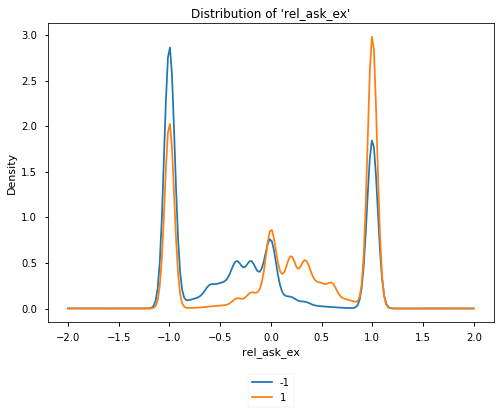

The correlation between 'rel_ask_ex' and the 'buy_sell' is  nan
Median value of sells = -0.3333
Median value of buys =  0.3200


In [100]:
plot_kde_target("rel_ask_ex", clip=[-2, 2])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

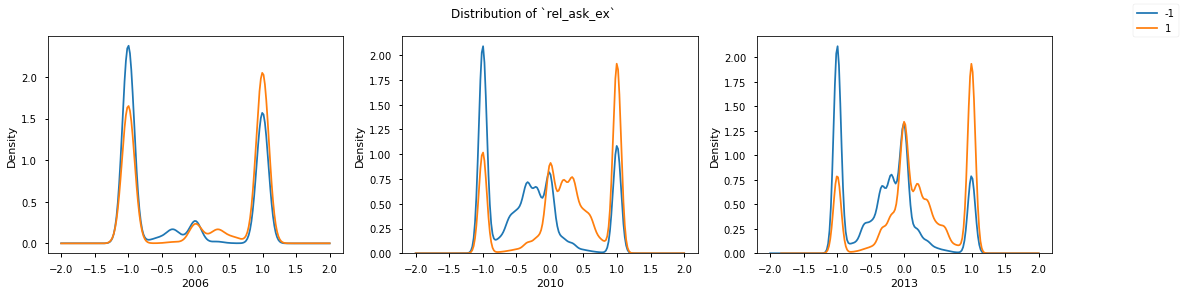

In [101]:
plot_kde_target_comparsion("rel_ask_ex", years=[2006, 2010, 2013], clip=[-2, 2])


#### Depth

Implicitly used in depth rule. Depth rule would assign a buy if `bid_ask_size_ratio_ex` is above one and a sell if it is below zero. But only used for mid-spread trades.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

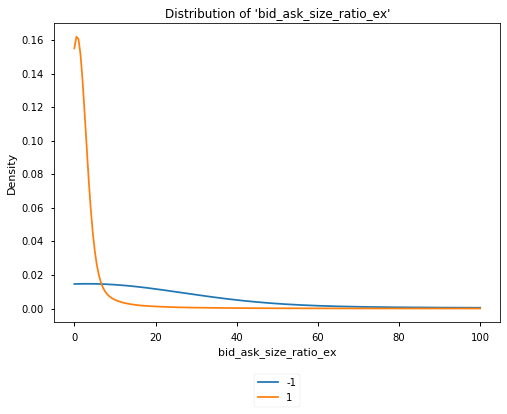

The correlation between 'bid_ask_size_ratio_ex' and the 'buy_sell' is  nan
Median value of sells =  1.3810
Median value of buys =  0.5780


In [102]:
plot_kde_target("bid_ask_size_ratio_ex", clip=[0, 100])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

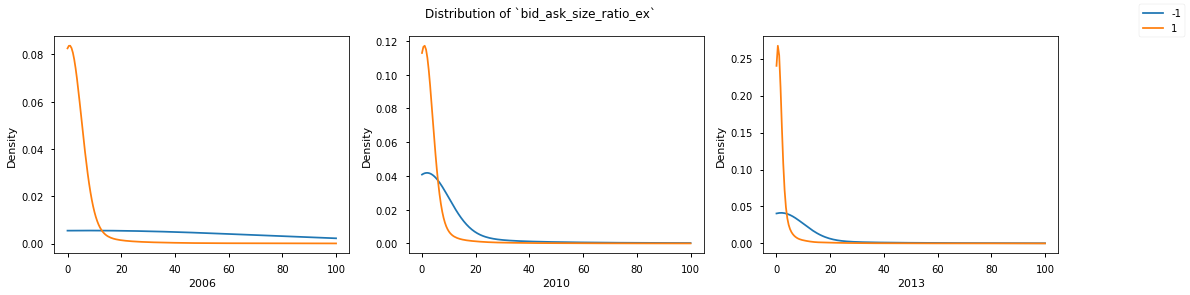

In [103]:
plot_kde_target_comparsion("bid_ask_size_ratio_ex", years=[2006, 2010, 2013], clip=[0, 100])


#### $\log$ bid ex

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

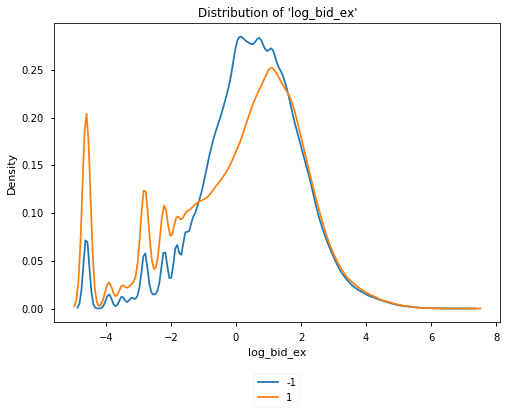

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1067
Median value of sells =  0.5653
Median value of buys =  0.5068


In [104]:
plot_kde_target("log_bid_ex")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

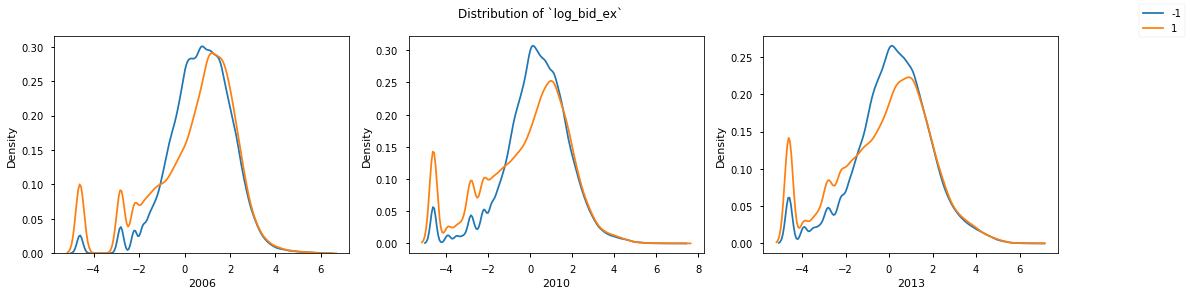

In [105]:
plot_kde_target_comparsion("log_bid_ex", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### $\log$ trade price

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

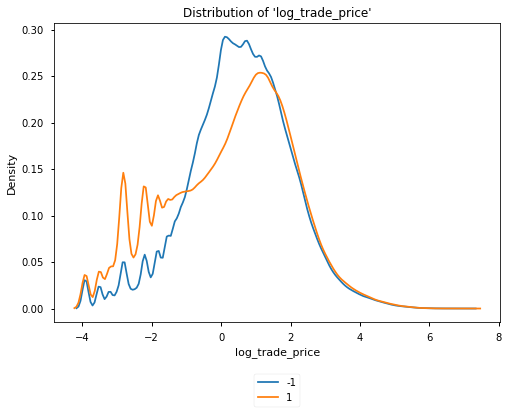

The correlation between 'log_trade_price' and the 'buy_sell' is -0.0778
Median value of sells =  0.5878
Median value of buys =  0.5481


In [106]:
plot_kde_target("log_trade_price")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

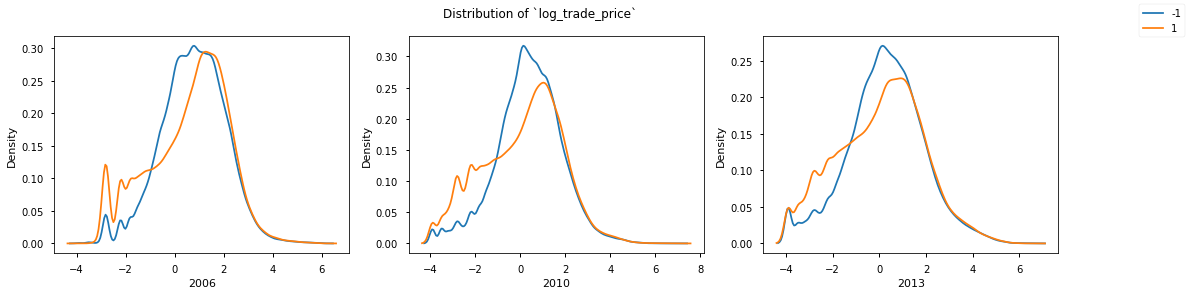

In [107]:
plot_kde_target_comparsion("log_trade_price", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### Ask size

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

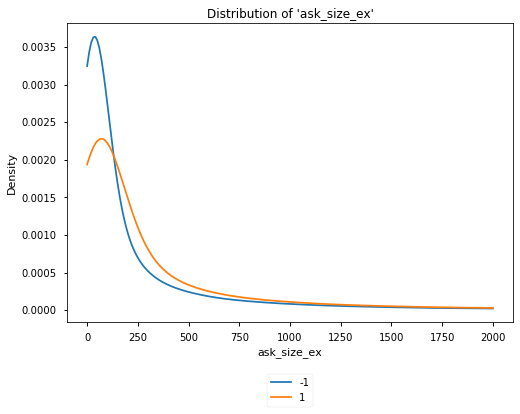

The correlation between 'ask_size_ex' and the 'buy_sell' is  0.0479
Median value of sells =  59.0000
Median value of buys =  102.0000


In [108]:
plot_kde_target("ask_size_ex", clip=[0, 2000])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

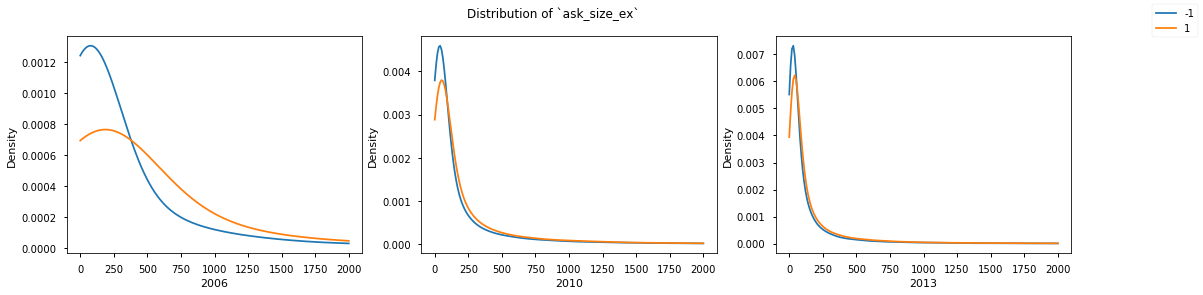

In [109]:
plot_kde_target_comparsion("ask_size_ex", years=[2006, 2010, 2013], clip=[0, 2000])


#### Bid size

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

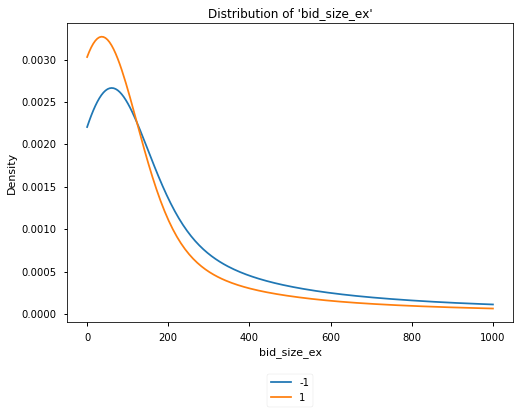

The correlation between 'bid_size_ex' and the 'buy_sell' is -0.0466
Median value of sells =  103.0000
Median value of buys =  47.0000


In [110]:
plot_kde_target("bid_size_ex", clip=[0, 1000])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

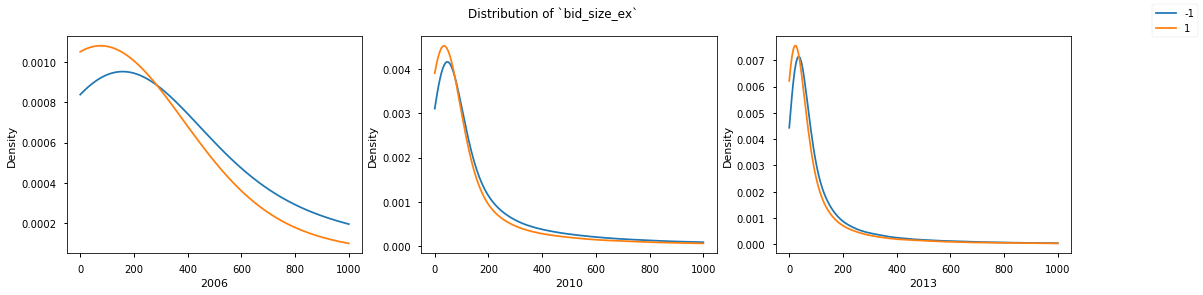

In [111]:
plot_kde_target_comparsion("bid_size_ex", years=[2006, 2010, 2013], clip=[0, 1000])


#### Quote rule

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

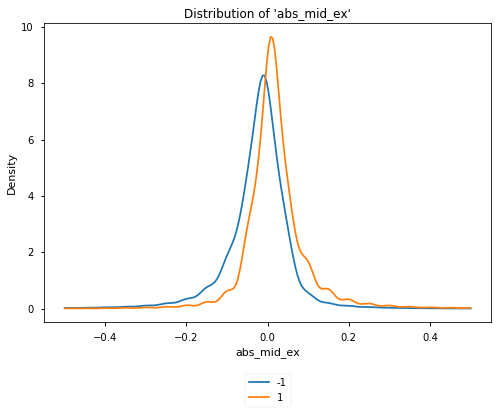

The correlation between 'abs_mid_ex' and the 'buy_sell' is  0.0821
Median value of sells = -0.0150
Median value of buys =  0.0100


In [112]:
plot_kde_target("abs_mid_ex", clip=[-0.5, 0.5])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

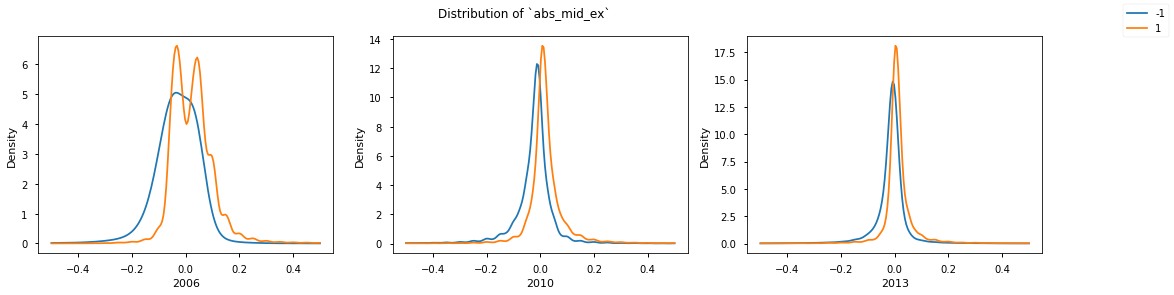

In [113]:
plot_kde_target_comparsion("abs_mid_ex", years=[2006, 2010, 2013], clip=[-0.5, 0.5])


**Observation:**
- Compared with tick rule or reverse tick rule, quote rule is the only classical rule, where distributions are somewhat distinguishable
- On can clearly see that the quote rule works better at the beginning of the data set and its performance worsens over time.

#### Day of the month

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

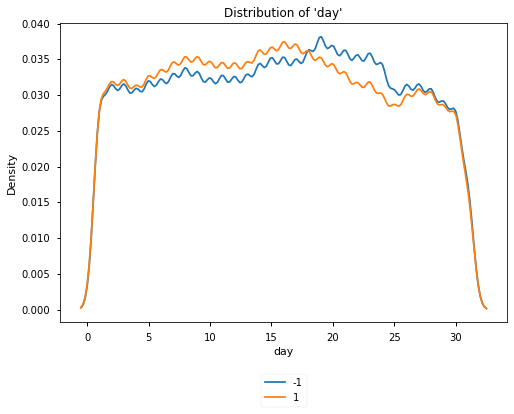

The correlation between 'day' and the 'buy_sell' is -0.0182
Median value of sells =  16.0000
Median value of buys =  15.0000


In [114]:
plot_kde_target("day")


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

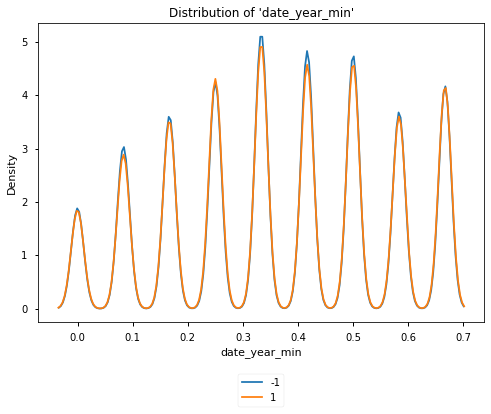

The correlation between 'date_year_min' and the 'buy_sell' is  0.0014
Median value of sells =  0.3333
Median value of buys =  0.3333


In [115]:
plot_kde_target("date_year_min")


**Observation:**
* Judging from the plot there seems to be a seasonal pattern e. g., more buys 
at the beginning of the month and more sells towards the end of the month. 
* Due to the distributions it could make sense to include date features in some feature sets. But do not include in the most basic data set.

## What doesn't ❌

#### tick rule

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

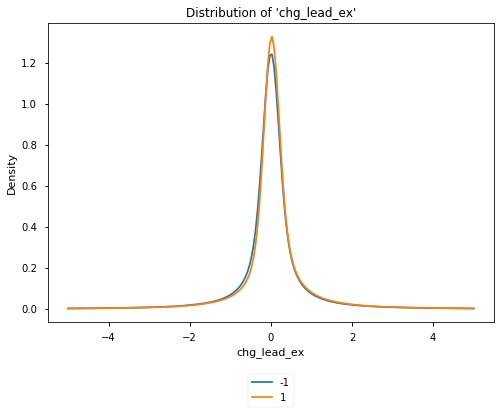

The correlation between 'chg_lead_ex' and the 'buy_sell' is  0.0112
Median value of sells =  0.0100
Median value of buys =  0.0200


In [116]:
plot_kde_target("chg_lead_ex", clip=[-5, 5])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

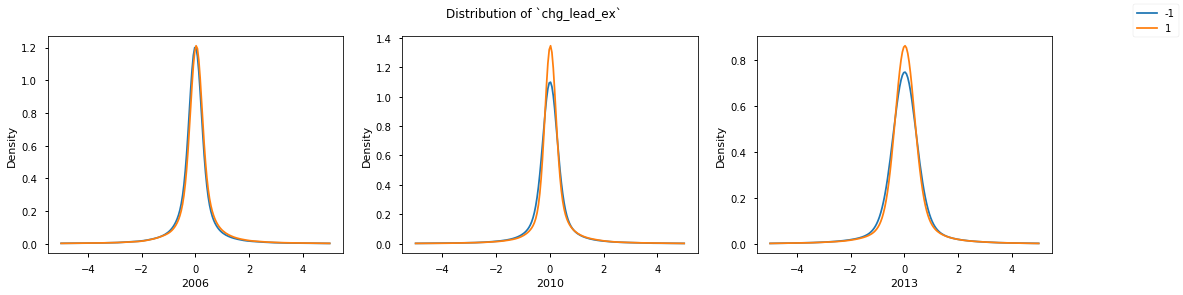

In [117]:
plot_kde_target_comparsion("chg_lead_ex", years=[2006, 2010, 2013], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results seem to worsen over time, which is consistent to the observations of Grauer et. al.

#### reverse tick rule

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

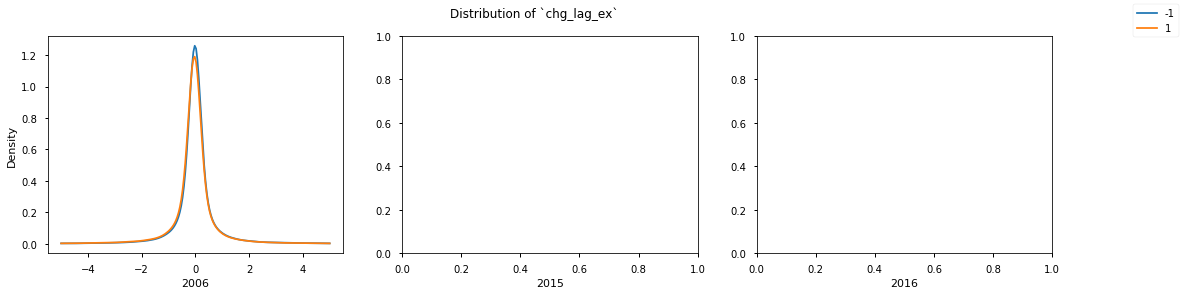

In [118]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

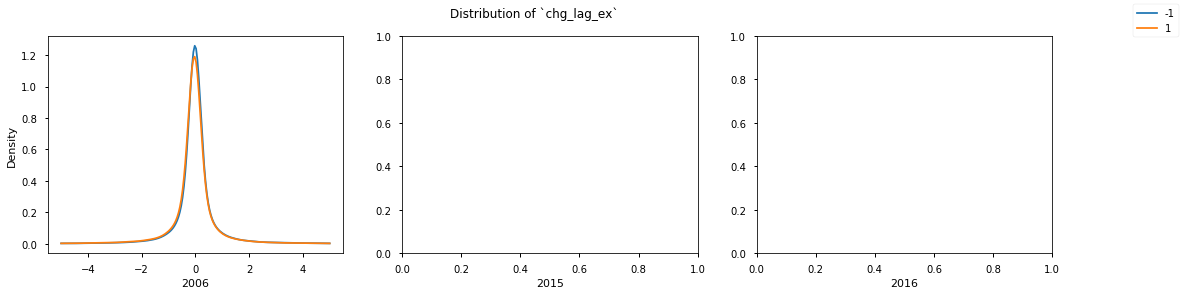

In [119]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results worsen over time.

# Impact of scaling 🔢

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

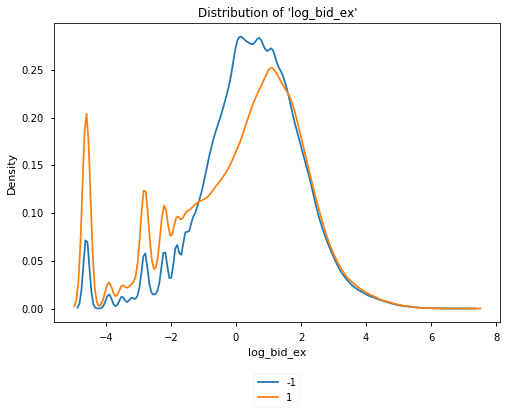

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1067
Median value of sells =  0.5653
Median value of buys =  0.5068


In [120]:
plot_kde_target("log_bid_ex", clip=[-5,8])

In [121]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [122]:
scaler = StandardScaler()
data["log_bid_ex_scaled"] = scaler.fit_transform(X=data["log_bid_ex"].values.reshape(-1,1))

In [123]:
data["log_bid_ex_scaled"].describe()

count    2.913070e+06
mean     2.642593e-09
std      1.000000e+00
min     -2.664345e+00
25%     -5.224892e-01
50%      1.365681e-01
75%      6.648672e-01
max      3.735018e+00
Name: log_bid_ex_scaled, dtype: float64

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

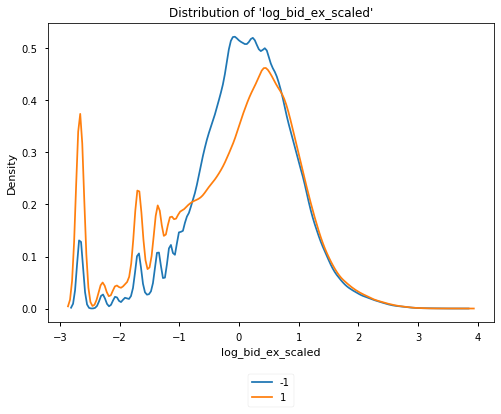

The correlation between 'log_bid_ex_scaled' and the 'buy_sell' is -0.1067
Median value of sells =  0.1523
Median value of buys =  0.1204


In [124]:
plot_kde_target("log_bid_ex_scaled", clip=[-5,5])

In [125]:
del data

# Cross-validation⛑️

In [126]:
oe_option_type = OrdinalEncoder(unknown_value=-1, dtype=int, handle_unknown="use_encoded_value")
oe_root = OrdinalEncoder(unknown_value=-1, dtype=int, handle_unknown="use_encoded_value")
oe_issue_type = OrdinalEncoder(unknown_value=-1, dtype=int, handle_unknown="use_encoded_value")

In [127]:
def transform(data:pd.DataFrame)->Tuple[pd.DataFrame, pd.Series]:

  add_const = 1e-2

  # date features
  x = pd.DataFrame(data = {"date_year":data["QUOTE_DATETIME"].dt.year}, index=data.index)

  x["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
  x["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

  seconds_in_day = 24 * 60 * 60
  seconds = (
      data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
  ).dt.total_seconds()

  x["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
  x["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

  # option features
  x["ttm"] = (
    data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
  ).apply(lambda x: x.n)
  x[["myn", "day_vol"]] = data[["myn", "day_vol"]]
  x["log_strk_prc"] = np.log(data["STRK_PRC"] + add_const)

  # binarize
  # "bin_OPTION_TYPE", "bin_issue_type", "bin_ROOT",

  # size features
  x["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]
  x["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
  x["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]
  x[["TRADE_SIZE", "bid_size_ex", "ask_size_ex"]] = data[["TRADE_SIZE", "bid_size_ex", "ask_size_ex"]]

  # classical
  mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
  mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])
  x["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
  x["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])
  x["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
  x["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])
  x["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]

  x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
  x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
  x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
  x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

  x[["log_ask_ex", "log_bid_ex", "log_BEST_ASK", "log_BEST_BID", "log_trade_price","log_price_all_lag", "log_price_all_lead", "log_price_ex_lag", "log_price_ex_lead"]] = np.log(data[["ask_ex", "bid_ex", "BEST_ASK", "BEST_BID", "TRADE_PRICE","price_all_lag", "price_all_lead", "price_ex_lag", "price_ex_lead"]]+add_const)

  # https://stackoverflow.com/questions/70727291/how-do-i-know-whether-a-sklearn-scaler-is-already-fitted-or-not

  if not hasattr(oe_option_type, "n_features_in_"):
    oe_option_type.fit(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))
  x["bin_option_type"] = oe_option_type.transform(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))

  if not hasattr(oe_root, "n_features_in_"):
    oe_root.fit(data["ROOT"].astype(str).values.reshape(-1, 1))
  x["bin_root"] = oe_root.transform(data["ROOT"].astype(str).values.reshape(-1, 1))

  if not hasattr(oe_issue_type, "n_features_in_"):
    oe_issue_type.fit(data["issue_type"].astype(str).values.reshape(-1, 1))
  x["bin_issue_type"] = oe_issue_type.transform(data["issue_type"].astype(str).values.reshape(-1, 1))

  x.replace([np.inf, -np.inf], np.nan,inplace=True)

  y = data["buy_sell"]
  return x, y



In [128]:
train = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet")
x_train, y_train = transform(train)

del train

In [129]:
val = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet")
x_val, y_val = transform(val)

del val

In [130]:
test= pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet")
x_test, y_test = transform(test)

del test

In [131]:
classical_features = ["BEST_rel_bid", "BEST_rel_ask", "rel_ask_ex", "rel_bid_ex", "bid_ask_ratio_ex", "log_ask_ex", "log_bid_ex", "log_BEST_ASK", 
                      "log_BEST_BID", "chg_ex_lag", "chg_ex_lead", "chg_all_lag", "chg_all_lead", "log_trade_price", "log_price_all_lag", "log_price_all_lead",
                      "log_price_ex_lag", "log_price_ex_lead"]

size_features = ["TRADE_SIZE", "bid_ask_size_ratio_ex", "rel_bid_size_ex", "rel_ask_size_ex", "bid_size_ex", "ask_size_ex"]
option_features = ["bin_option_type", "bin_issue_type", "bin_root", "myn", "log_strk_prc", "ttm", "day_vol"] 
date_features = ["date_time_cos", "date_time_sin", "date_month_cos","date_month_sin", "date_year"]

cat_features = ["bin_root", "bin_issue_type", "bin_option_type"]

In [132]:
def evaluate(features:List[str], cat_features:Optional[List[str]]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

  params = {
            "od_type": "Iter",
            "logging_level": "Silent",
            "depth":8,
            "loss_function": "Logloss",
            "task_type": "GPU",
            "cat_features": cat_features,
            "random_seed": 42,
  }

  res = cross_validate(CatBoostClassifier(**params), x_train[features], y_train, cv=5, return_estimator=True)
  results_cv = pd.DataFrame(res["test_score"], columns=["test_score_cv"])
  print(res)

  oos = []
  feature_importances = []
  for i, model in enumerate(res['estimator']):

    oos.append([i, model.score(x_train[features],y_train), model.score(x_val[features], y_val), model.score(x_test[features],y_test)])
    
    feature_importance = model.get_feature_importance(prettified=True).add_prefix(f"fold_{i}_")
    feature_importances.append(feature_importance)
  
  results_oos = pd.DataFrame(data = oos, columns=["fold", "acc_train", "acc_val","acc_test"])
  results_fi = pd.concat(feature_importances, axis=1)

  return results_cv, results_oos, results_fi

In [133]:
results_cv, results_oos, results_fi = evaluate(classical_features, [])

/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


{'fit_time': array([122.54278207, 120.13019061, 120.19042563, 120.4700706 ,
       119.63457203]), 'score_time': array([1.90102601, 1.89836502, 1.82252097, 1.83219838, 1.86158705]), 'estimator': [<catboost.core.CatBoostClassifier object at 0x7f8a30b02130>, <catboost.core.CatBoostClassifier object at 0x7f8a30442820>, <catboost.core.CatBoostClassifier object at 0x7f8a30442580>, <catboost.core.CatBoostClassifier object at 0x7f8a30442ac0>, <catboost.core.CatBoostClassifier object at 0x7f8a31471940>], 'test_score': array([0.76049345, 0.74220341, 0.7684876 , 0.7783799 , 0.74572353])}


/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items i

In [134]:
results_cv

,test_score_cv
0,0.760493
1,0.742203
2,0.768488
3,0.778380
4,0.745724


In [135]:
results_oos

,fold,acc_train,acc_val,acc_test
0,0,0.765290,0.628572,0.620694
1,1,0.769852,0.625648,0.619935
2,2,0.770166,0.626542,0.621111
3,3,0.769631,0.626352,0.622645
4,4,0.770308,0.619728,0.607695


In [136]:
results_fi

,fold_0_Feature Id,fold_0_Importances,fold_1_Feature Id,fold_1_Importances,fold_2_Feature Id,fold_2_Importances,fold_3_Feature Id,fold_3_Importances,fold_4_Feature Id,fold_4_Importances
0,rel_ask_ex,21.286573,rel_ask_ex,17.134563,rel_ask_ex,19.142892,bid_ask_ratio_ex,18.618778,rel_ask_ex,20.388614
1,rel_bid_ex,17.079992,rel_bid_ex,16.928217,bid_ask_ratio_ex,18.014234,rel_ask_ex,18.203993,bid_ask_ratio_ex,17.787172
2,bid_ask_ratio_ex,11.700958,bid_ask_ratio_ex,16.315752,rel_bid_ex,13.956667,rel_bid_ex,14.946922,rel_bid_ex,15.851759
3,BEST_rel_ask,9.549618,BEST_rel_ask,9.001083,BEST_rel_ask,8.720511,BEST_rel_ask,9.891682,BEST_rel_ask,8.198600
4,BEST_rel_bid,7.892139,BEST_rel_bid,7.542476,BEST_rel_bid,7.497721,BEST_rel_bid,7.810299,log_BEST_ASK,6.644898
5,chg_all_lead,7.811588,chg_all_lead,6.427715,chg_all_lead,6.656815,log_BEST_ASK,7.315856,BEST_rel_bid,6.415776
6,chg_all_lag,5.155219,log_ask_ex,6.002951,log_BEST_ASK,6.331365,chg_all_lead,5.465571,chg_all_lead,5.588356
7,log_BEST_ASK,4.026463,log_BEST_ASK,5.412593,log_ask_ex,5.011649,log_ask_ex,4.952556,log_ask_ex,5.548009
8,log_ask_ex,3.957145,chg_all_lag,3.762512,chg_all_lag,3.627129,chg_all_lag,2.804045,chg_all_lag,3.379406
9,log_price_all_lead,3.105337,log_price_all_lead,3.228904,log_price_all_lead,3.078569,log_price_all_lead,2.738033,log_price_all_lead,2.673470


In [137]:
results_cv, results_oos, results_fi = evaluate([*classical_features,*size_features], [])

/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


{'fit_time': array([124.30857539, 125.07514   , 124.72022939, 123.68532062,
       123.47671437]), 'score_time': array([1.76957679, 1.9393959 , 1.96350861, 1.92797446, 1.8573184 ]), 'estimator': [<catboost.core.CatBoostClassifier object at 0x7f8b1aee84f0>, <catboost.core.CatBoostClassifier object at 0x7f8a30405c70>, <catboost.core.CatBoostClassifier object at 0x7f8a30405d00>, <catboost.core.CatBoostClassifier object at 0x7f8a30405850>, <catboost.core.CatBoostClassifier object at 0x7f8a30405bb0>], 'test_score': array([0.87283144, 0.87264676, 0.85438026, 0.85352887, 0.82923618])}


/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items i

In [138]:
results_cv

,test_score_cv
0,0.872831
1,0.872647
2,0.854380
3,0.853529
4,0.829236


In [139]:
results_oos

,fold,acc_train,acc_val,acc_test
0,0,0.860547,0.735476,0.710197
1,1,0.861668,0.735516,0.710486
2,2,0.861400,0.734039,0.709707
3,3,0.861855,0.733018,0.709933
4,4,0.862100,0.727325,0.699467


In [140]:
results_fi

,fold_0_Feature Id,fold_0_Importances,fold_1_Feature Id,fold_1_Importances,fold_2_Feature Id,fold_2_Importances,fold_3_Feature Id,fold_3_Importances,fold_4_Feature Id,fold_4_Importances
0,rel_bid_ex,13.130888,rel_bid_ex,13.758387,rel_bid_ex,12.080753,ask_size_ex,10.634997,rel_bid_ex,11.485927
1,ask_size_ex,11.071850,bid_ask_size_ratio_ex,10.654470,bid_ask_size_ratio_ex,9.561516,bid_size_ex,10.133313,bid_ask_size_ratio_ex,10.683193
2,bid_size_ex,10.820762,ask_size_ex,9.181244,ask_size_ex,9.489953,bid_ask_size_ratio_ex,9.911366,ask_size_ex,9.319278
3,bid_ask_size_ratio_ex,9.739679,bid_size_ex,8.803186,bid_size_ex,9.111690,rel_bid_ex,9.836934,bid_size_ex,9.190778
4,rel_ask_ex,8.740075,rel_ask_ex,7.286041,rel_bid_size_ex,8.413457,rel_ask_ex,9.082584,rel_ask_ex,8.019433
5,rel_bid_size_ex,7.440473,rel_bid_size_ex,6.827161,rel_ask_ex,7.090160,rel_bid_size_ex,7.807913,rel_bid_size_ex,7.558687
6,BEST_rel_ask,6.342184,BEST_rel_ask,6.295267,bid_ask_ratio_ex,7.074711,bid_ask_ratio_ex,7.006307,TRADE_SIZE,6.918635
7,BEST_rel_bid,5.981642,bid_ask_ratio_ex,6.118620,BEST_rel_ask,6.281315,BEST_rel_ask,6.676537,bid_ask_ratio_ex,6.408667
8,TRADE_SIZE,4.930358,BEST_rel_bid,6.115981,BEST_rel_bid,5.585511,BEST_rel_bid,5.573180,BEST_rel_ask,6.248127
9,rel_ask_size_ex,4.623361,TRADE_SIZE,5.257955,rel_ask_size_ex,5.233146,TRADE_SIZE,5.023996,BEST_rel_bid,5.183115


In [142]:
results_cv, results_oos, results_fi = evaluate([*classical_features,*size_features, *date_features, *option_features], cat_features)

/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


{'fit_time': array([717.26521111, 718.94335651, 714.04680967, 721.05258846,
       727.33295441]), 'score_time': array([14.13975453, 14.1220634 , 12.56098771, 13.89941549, 13.48006535]), 'estimator': [<catboost.core.CatBoostClassifier object at 0x7f8a31471f70>, <catboost.core.CatBoostClassifier object at 0x7f8a305aac40>, <catboost.core.CatBoostClassifier object at 0x7f8a308e0e50>, <catboost.core.CatBoostClassifier object at 0x7f8a30e44130>, <catboost.core.CatBoostClassifier object at 0x7f8a3095eb50>], 'test_score': array([0.89529138, 0.89086699, 0.87532226, 0.86896821, 0.84217318])}


/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items i

In [143]:
results_cv

,test_score_cv
0,0.895291
1,0.890867
2,0.875322
3,0.868968
4,0.842173


In [144]:
results_oos

,fold,acc_train,acc_val,acc_test
0,0,0.884846,0.749889,0.721447
1,1,0.886512,0.749585,0.722010
2,2,0.885977,0.748076,0.721347
3,3,0.887120,0.746798,0.719772
4,4,0.887929,0.737833,0.707671


In [145]:
results_fi

,fold_0_Feature Id,fold_0_Importances,fold_1_Feature Id,fold_1_Importances,fold_2_Feature Id,fold_2_Importances,fold_3_Feature Id,fold_3_Importances,fold_4_Feature Id,fold_4_Importances
0,rel_bid_ex,11.807491,rel_bid_ex,12.074243,day_vol,11.925637,day_vol,12.145599,day_vol,12.564957
1,ask_size_ex,11.125458,day_vol,11.048880,bid_size_ex,10.397263,bid_size_ex,11.076881,bid_size_ex,10.282951
2,day_vol,11.057671,ask_size_ex,9.134975,ask_size_ex,9.761748,ask_size_ex,10.141350,rel_bid_ex,9.980509
3,bid_size_ex,10.244053,bid_size_ex,8.997557,rel_bid_ex,9.518588,rel_ask_ex,10.096116,ask_size_ex,9.679502
4,rel_ask_ex,9.085506,rel_ask_ex,8.548454,rel_ask_ex,9.187706,bid_ask_size_ratio_ex,8.148755,rel_ask_ex,9.016608
5,bid_ask_size_ratio_ex,7.537089,bid_ask_size_ratio_ex,8.243067,bid_ask_size_ratio_ex,7.439836,rel_bid_ex,8.147745,bid_ask_size_ratio_ex,8.424661
6,BEST_rel_ask,5.347320,BEST_rel_ask,5.387487,BEST_rel_ask,5.546142,BEST_rel_ask,5.561962,rel_bid_size_ex,5.198617
7,rel_bid_size_ex,5.329634,BEST_rel_bid,4.931053,rel_bid_size_ex,5.410989,BEST_rel_bid,4.924510,BEST_rel_ask,4.909203
8,BEST_rel_bid,4.693825,rel_bid_size_ex,4.833054,BEST_rel_bid,4.620492,rel_bid_size_ex,4.859183,BEST_rel_bid,4.559583
9,rel_ask_size_ex,2.904472,bid_ask_ratio_ex,3.636197,bid_ask_ratio_ex,4.155642,bid_ask_ratio_ex,4.041667,bid_ask_ratio_ex,3.925597


# Conclusion 🔗

**Observation:**
- log on size seems to worsen results, but improves results for prices
- `TODO:` investigate further, what the reason is. e. g., some skewness, but outliers...
- `TODO:` investigate further, if there is an economic intuition behind it
- Classical features have hardly any importance. But keep them for comparsion
- Features of Grauer et. al seem to work
- Binning gives mixed results e. g., for trade size and ttm
- `TODO:` update [feature proposal](https://github.com/KarelZe/thesis/blob/main/references/obsidian/%F0%9F%8D%ACImplementation/%F0%9F%A7%AAFeature%20Engineering/%F0%9F%A7%83Feature%20Sets.md) accordingly
- `TODO:` Correlation is a common method for feature selection https://en.wikipedia.org/wiki/Feature_selection#Filter_method
- `TODO:` Perform cross-validation and calculate AUC on train, validation and test set
- `TODO:` Remove highly correlated columns if possible
- `TODO:` Results are not suprising, when compared with feature importances of first gbm (taken from [this notebook](https://github.com/KarelZe/thesis/blob/d0e078a8030e1ba47b761b4a1abfc699a629ca0a/notebooks/3.0-mb-feature_engineering_baseline.ipynb)):
